In [1]:
%matplotlib inline

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear() 
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import trades, plots, params, feats, strategies, models_core
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strategies)
importlib.reload(models_core)

<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import glob
import os
import json
import re
import os
import psutil
import math
from re import findall

import time
from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])

# from tqdm.auto import tqdm
from tqdm import tqdm
import json
from PIL import Image
import IPython.display as disp
from IPython.display import clear_output, display

# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import seaborn as sns
from pprint import pprint

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage

In [3]:
# ##############################
# ###### ML STRATEGIES DF ######
# ##############################

# df_trainval = pd.read_csv(params.trainval_csv, index_col=0, parse_dates=True)
# baseline_pnl = round((df_trainval["bid"].iloc[-1] - df_trainval["ask"].iloc[0]) / df_trainval.index.normalize().nunique(),4)
# print('baseline profit & loss per day:', baseline_pnl)
# df_trainval

In [4]:
##############################
## INDICATORS STRATEGIES DF ##
##############################

# Read sign timestamps ( since selected year, with pre-market included)
df_inds_trainval = pd.read_csv(params.indunsc_trainval_csv, index_col=0, parse_dates=True)
# compute synthetic ask/bid from close_raw and configured spread
df_inds_trainval['ask'] = df_inds_trainval['close'] * (1 + params.bidask_spread_pct/100)
df_inds_trainval['bid'] = df_inds_trainval['close'] * (1 - params.bidask_spread_pct/100)

df_inds_trainval

,open,high,low,close,volume,signal,ret,log_ret,sma_9,sma_21,sma_pct_9,sma_pct_21,ema_9,ema_21,roc_9,roc_21,body,body_pct,upper_shad,lower_shad,range_pct,rsi_6,macd_line,macd_signal,macd_diff,atr_14,atr_pct_14,bb_lband_20,bb_hband_20,bb_w_20,plus_di,minus_di,adx,obv,vwap_14,vwap_dev_pct_14,vol_spike,vol_z_14,rolling_max_close_21,rolling_min_close_21,dist_high_21,dist_low_21,obv_sma,obv_diff_14,obv_pct_14,obv_sma_14,obv_z_14,ret_30,sma_30,sma_pct_30,ema_30,roc_30,rsi_30,atr_30,atr_pct_30,bb_lband_30,bb_hband_30,bb_w_30,plus_di_30,minus_di_30,adx_30,obv_diff_30,obv_pct_30,obv_sma_30,obv_z_30,vwap_30,vwap_dev_pct_30,z_vwap_dev_30,vol_spike_30,vol_z_30,ret_std_30,rolling_max_close_30,rolling_min_close_30,dist_high_30,dist_low_30,macd_line_30,macd_signal_30,macd_diff_30,ret_45,sma_45,sma_pct_45,ema_45,roc_45,rsi_45,atr_45,atr_pct_45,bb_lband_45,bb_hband_45,bb_w_45,plus_di_45,minus_di_45,adx_45,obv_diff_45,obv_pct_45,obv_sma_45,obv_z_45,vwap_45,vwap_dev_pct_45,z_vwap_dev_45,vol_spike_45,vol_z_45,ret_std_45,rolling_max_close_45,rolling_min_close_45,dist_high_45,dist_low_45,macd_line_45,macd_signal_45,macd_diff_45,ret_60,sma_60,sma_pct_60,ema_60,roc_60,rsi_60,atr_60,atr_pct_60,bb_lband_60,bb_hband_60,bb_w_60,plus_di_60,minus_di_60,adx_60,obv_diff_60,obv_pct_60,obv_sma_60,obv_z_60,vwap_60,vwap_dev_pct_60,z_vwap_dev_60,vol_spike_60,vol_z_60,ret_std_60,rolling_max_close_60,rolling_min_close_60,dist_high_60,dist_low_60,macd_line_60,macd_signal_60,macd_diff_60,volume_z_30,vol_spike_z_30,ret_std_z_30,obv_pct_z_30,vwap_dev_pct_z_30,bb_w_z_30,atr_z_30,macd_diff_z_30,volume_z_45,vol_spike_z_45,ret_std_z_45,obv_pct_z_45,vwap_dev_pct_z_45,bb_w_z_45,atr_z_45,macd_diff_z_45,volume_z_60,vol_spike_z_60,ret_std_z_60,obv_pct_z_60,vwap_dev_pct_z_60,bb_w_z_60,atr_z_60,macd_diff_z_60,minute_time,hour_time,dow_time,month_time,day_of_year_time,week_of_year_time,in_sess_time,eng_ma,eng_macd,eng_bb,eng_bb_mid,eng_rsi,eng_adx,eng_obv,eng_atr_div,z_eng_atr,eng_sma_short,eng_sma_long,eng_vwap,z_vwap_dev,z_bb_w,z_obv,mom_sum_30,mom_std_30,mom_sum_45,mom_std_45,mom_sum_60,mom_std_60,eng_ema_cross_up,eng_ema_cross_down,ask,bid
2009-01-02 10:58:00,3.069643,3.069643,3.069643,3.069643,13160.0,1.645129e-12,0.000000,0.000000,3.069643,3.069643,0.000000,0.000000,3.069643,3.069643,0.000000,0.000000,0.0000,0.000000,0.00,0.0000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.069643,3.069643,0.000000,0.000000,0.000000,0.000000,1566040.0,3.069643,0.000000,1.000000,0.000000,3.069643,3.069643,0.000000,0.000000,1.480500e+06,184240.0,60020.011635,1.480500e+06,1.553797,0.000000,3.069643,0.000000,3.069643,0.000000,100.000000,0.000000,0.000000,3.069643,3.069643,0.000000,0.000000,0.000000,0.000000,394800.0,128614.310646,1.375220e+06,0.674491,3.069643,-1.446713e-14,0.000000,1.000000,0.000000,0.000000,3.069643,3.069643,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.069643,0.000000,3.069643,0.000000,100.000000,0.000000,0.000000,3.069643,3.069643,0.000000,0.000000,0.000000,0.000000,592200.0,192921.465969,1.276520e+06,0.674491,3.069643,-1.446713e-14,0.000000,1.000000,0.000000,0.000000,3.069643,3.069643,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.069643,0.000000,3.069643,0.000000,100.000000,0.000000,0.000000,3.069643,3.069643,0.000000,0.000000,0.000000,0.000000,789600.0,257228.621291,1.177820e+06,0.674491,3.069643,-1.446713e-14,0.000000,1.000000,0.000000,0.000000,3.069643,3.069643,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.352778,0.312500,0.071429,0.500000,0.502740,0.500000,0.0,0.000000,0.000000,0.0,0.000000,0.30000,0.000000,0.127854,0.000000,0.000000,0.000000,0.000000,-100.000000,0.000000,0.000000,1.388730,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,3.070257,3.069029
2009-01-02 10:59:00,3.069643,3.069643,3.069643,3.0

In [5]:
df = df_inds_trainval # SELECT THE CORRECT DATAFRAME

baseline_pnl = round((df["bid"].iloc[-1] - df["ask"].iloc[0]) / df.index.normalize().nunique(),4)
baseline_pnl

0.0367

In [6]:
trading_combinations = {
    "tc_001": {"col_signal":"ema_9",               "sign_thresh":"ema_21"},
    "tc_002": {"col_signal":"sma_9",               "sign_thresh":"sma_21"},
    "tc_003": {"col_signal":"close",               "sign_thresh":"ema_9"},
    "tc_004": {"col_signal":"close",               "sign_thresh":"ema_21"},
    "tc_005": {"col_signal":"macd_line",            "sign_thresh":"macd_signal"},
    "tc_006": {"col_signal":"macd_diff",            "sign_thresh":0.0},
    "tc_007": {"col_signal":"dist_low_21",          "sign_thresh":0.0},
    "tc_008": {"col_signal":"dist_high_21",         "sign_thresh":0.0},
    "tc_009": {"col_signal":"sma_pct_9",            "sign_thresh":0.0},
    "tc_010": {"col_signal":"sma_pct_21",           "sign_thresh":0.0},
    "tc_011": {"col_signal":"roc_9",                "sign_thresh":0.0},
    "tc_012": {"col_signal":"roc_21",               "sign_thresh":0.0},
    "tc_013": {"col_signal":"vwap_dev_pct_14",      "sign_thresh":0.0},
    "tc_014": {"col_signal":"obv_pct_14",           "sign_thresh":0.0},
    "tc_015": {"col_signal":"vol_spike",            "sign_thresh":1.0},
    "tc_016": {"col_signal":"rolling_max_close_21", "sign_thresh":"dist_high_21"},
    "tc_017": {"col_signal":"rolling_min_close_21", "sign_thresh":"dist_low_21"},
    "tc_018": {"col_signal":"obv_sma",              "sign_thresh":"obv_sma_14"},
    "tc_019": {"col_signal":"obv_diff_14",          "sign_thresh":0.0},
    "tc_020": {"col_signal":"obv_z_14",             "sign_thresh":0.0},
    "tc_021": {"col_signal":"body_pct",             "sign_thresh":0.0},
    "tc_022": {"col_signal":"upper_shad",           "sign_thresh":"range_pct"},
    "tc_023": {"col_signal":"lower_shad",           "sign_thresh":"range_pct"},
    "tc_024": {"col_signal":"plus_di",              "sign_thresh":"minus_di"},
    "tc_025": {"col_signal":"adx",                  "sign_thresh":20.0},
    "tc_026": {"col_signal":"bb_w_20",              "sign_thresh":0.0},
    "tc_027": {"col_signal":"atr_14",               "sign_thresh":"atr_pct_14"},
    "tc_028": {"col_signal":"atr_pct_14",           "sign_thresh":0.0},
    "tc_029": {"col_signal":"ret",                  "sign_thresh":0.0},
    "tc_030": {"col_signal":"log_ret",              "sign_thresh":0.0},
    "tc_031": {"col_signal":"ema_9",               "sign_thresh":"vwap_dev_pct_14"},
    "tc_032": {"col_signal":"sma_9",               "sign_thresh":"vwap_dev_pct_14"},
    "tc_033": {"col_signal":"macd_line",            "sign_thresh":"ema_9"},
    "tc_034": {"col_signal":"macd_line",            "sign_thresh":"ema_21"},
    "tc_035": {"col_signal":"sma_pct_9",            "sign_thresh":"sma_pct_21"},
    "tc_036": {"col_signal":"vwap_dev_pct_14",      "sign_thresh":"sma_pct_9"},
    "tc_037": {"col_signal":"roc_9",                "sign_thresh":"ema_21"},
    "tc_038": {"col_signal":"vol_z_14",             "sign_thresh":1.5},
    "tc_039": {"col_signal":"rolling_min_close_21", "sign_thresh":"ema_9"},
    "tc_040": {"col_signal":"rolling_max_close_21", "sign_thresh":"ema_21"},
    "tc_041": {"col_signal":"obv_pct_14",           "sign_thresh":"obv_sma_14"},
    "tc_042": {"col_signal":"obv_diff_14",          "sign_thresh":"obv_sma_14"},
    "tc_043": {"col_signal":"body",                 "sign_thresh":0.0},
    "tc_044": {"col_signal":"range_pct",            "sign_thresh":0.0},
    "tc_045": {"col_signal":"ema_9",               "sign_thresh":"sma_21"},
    "tc_046": {"col_signal":"sma_9",               "sign_thresh":"ema_21"},
    "tc_047": {"col_signal":"bb_w_20",              "sign_thresh":"roc_9"},
    "tc_048": {"col_signal":"vwap_dev_pct_14",      "sign_thresh":"roc_9"},
}


In [7]:
# Pre-compute per-day slices once
groups = df.groupby(df.index.normalize())
prun_perc = 80 # higher value means the pruner keeps more trials (e.g., 90 keeps the top 10%)
report_interval = 50
_findall = re.compile(r"[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?").findall

def objective(trial: optuna.Trial) -> float:
    
    sellmin_idx    = trial.suggest_categorical("sellmin_idx", [None, -1, -2, -3])
    trailstop_pct = trial.suggest_float("trailstop_pct", 0.01, 0.30, log=True)
    rsi_thresh    = trial.suggest_int("rsi_thresh", 30, 75)
    atr_mult      = trial.suggest_float("atr_mult", 0.1, 6.0, log=True)
    vwap_atr_mult = trial.suggest_float("vwap_atr_mult", -4.0, 4.0)
    trad_comb      = trading_combinations[trial.suggest_categorical("tc_id", list(trading_combinations.keys()))]
    sess_start     = time.fromisoformat(trial.suggest_categorical("sess_start", [params.sess_start_pred.isoformat(), params.sess_start_reg.isoformat()]))

    print('-' * 150)
    print(f"Params => sellmin_idx={sellmin_idx}, trailstop_pct={trailstop_pct:.4f}, rsi_thresh={rsi_thresh:.2f}, atr_mult={atr_mult:.3f}, vwap_atr_mult={vwap_atr_mult:.3f}, sess_start={sess_start}")
    
    daily_pnls: List[float] = []
    pbar = tqdm(groups, desc=f"Trial {trial.number}", leave=True)
    for step, (day, df_day) in enumerate(pbar, 1):

        df_actions = strategies.generate_tradact_elab(
            df              = df_day,
            col_signal      = trad_comb["col_signal"],
            sign_thresh     = trad_comb["sign_thresh"],
            col_atr         = "atr_14",
            col_rsi         = "rsi_6",
            col_vwap        = "vwap_14",
            sellmin_idx     = sellmin_idx,
            trailstop_pct   = trailstop_pct,
            rsi_thresh      = rsi_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            sess_start      = sess_start
        )

        sim = strategies.simulate_trading(
            day               = day,
            df                = df_actions,
            sellmin_idx       = sellmin_idx, 
            sess_start        = sess_start
        )
   
        _, _, stats = next(iter(sim.values()))
        
        strategy_val = float(_findall(stats["STRATEGY"])[-1]) 

        daily_pnls.append(strategy_val)

        # Explicitly delete large locals at the end of each trial (no per-iteration gc.collect)
        del df_actions, sim, stats
        df_day = df_actions = sim = stats = None

        # Rreport for pruning
        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = float(np.mean(daily_pnls))
            trial.report(prun_val, report_step)
            if trial.should_prune():
                vals = [t.intermediate_values[report_step]
                        for t in trial.study.get_trials(deepcopy=False)
                        if t.state == TrialState.COMPLETE and report_step in t.intermediate_values]
                thr = float(__import__("numpy").percentile(vals, prun_perc))
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    # Average daily P&L
    return float(np.mean(daily_pnls))


------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0159, rsi_thresh=53.00, atr_mult=0.156, vwap_atr_mult=2.956, sess_start=14:30:00


Trial 0: 100%|██████████| 3519/3519 [03:29<00:00, 16.81it/s]


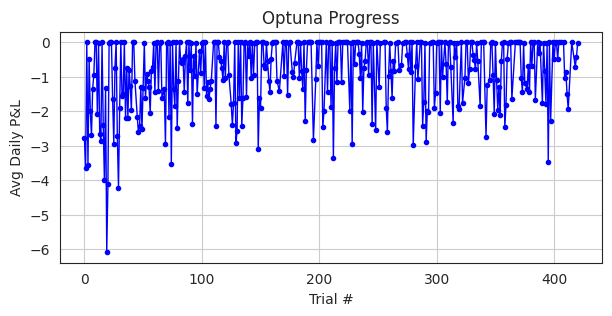

[Results] Trial 0 finished with value: -2.7891. Improvement over baseline: -7699.78%.     Best is trial 0 with value: -2.7891.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0213, rsi_thresh=54.00, atr_mult=0.477, vwap_atr_mult=0.756, sess_start=13:30:00


Trial 1: 100%|██████████| 3519/3519 [03:59<00:00, 14.69it/s]


[Results] Trial 1 finished with value: -3.6522. Improvement over baseline: -10051.36%.     Best is trial 0 with value: -2.7891.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1517, rsi_thresh=68.00, atr_mult=0.177, vwap_atr_mult=3.671, sess_start=13:30:00


Trial 2: 100%|██████████| 3519/3519 [01:38<00:00, 35.61it/s]


[Results] Trial 2 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.0290, rsi_thresh=50.00, atr_mult=3.084, vwap_atr_mult=-1.444, sess_start=13:30:00


Trial 3: 100%|██████████| 3519/3519 [04:38<00:00, 12.64it/s]


[Results] Trial 3 finished with value: -3.5491. Improvement over baseline: -9770.66%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.2346, rsi_thresh=70.00, atr_mult=1.426, vwap_atr_mult=0.008, sess_start=14:30:00


Trial 4: 100%|██████████| 3519/3519 [02:26<00:00, 24.06it/s]


[Results] Trial 4 finished with value: -0.4929. Improvement over baseline: -1443.11%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0878, rsi_thresh=42.00, atr_mult=0.922, vwap_atr_mult=3.340, sess_start=14:30:00


Trial 5: 100%|██████████| 3519/3519 [03:01<00:00, 19.38it/s]


[Results] Trial 5 finished with value: -2.0035. Improvement over baseline: -5559.13%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.1593, rsi_thresh=37.00, atr_mult=0.535, vwap_atr_mult=-3.251, sess_start=13:30:00


Trial 6: 100%|██████████| 3519/3519 [04:18<00:00, 13.61it/s]


[Results] Trial 6 finished with value: -2.7004. Improvement over baseline: -7458.10%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.1261, rsi_thresh=63.00, atr_mult=0.935, vwap_atr_mult=2.226, sess_start=13:30:00


Trial 7: 100%|██████████| 3519/3519 [03:15<00:00, 18.02it/s]


[Results] Trial 7 finished with value: -1.3425. Improvement over baseline: -3757.92%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0498, rsi_thresh=68.00, atr_mult=0.205, vwap_atr_mult=2.873, sess_start=13:30:00


Trial 8: 100%|██████████| 3519/3519 [01:57<00:00, 29.99it/s]


[Results] Trial 8 finished with value: -0.9486. Improvement over baseline: -2684.61%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.0546, rsi_thresh=63.00, atr_mult=0.138, vwap_atr_mult=2.878, sess_start=14:30:00


Trial 9: 100%|██████████| 3519/3519 [01:50<00:00, 31.79it/s]


[Results] Trial 9 finished with value: -0.0000. Improvement over baseline: -100.04%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2670, rsi_thresh=75.00, atr_mult=0.295, vwap_atr_mult=1.397, sess_start=13:30:00


Trial 10: 100%|██████████| 3519/3519 [01:57<00:00, 29.90it/s]


[Results] Trial 10 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2025, rsi_thresh=75.00, atr_mult=0.293, vwap_atr_mult=1.237, sess_start=13:30:00


Trial 11: 100%|██████████| 3519/3519 [03:31<00:00, 16.65it/s]


[Results] Trial 11 finished with value: -2.0836. Improvement over baseline: -5777.36%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2487, rsi_thresh=74.00, atr_mult=0.313, vwap_atr_mult=3.901, sess_start=13:30:00


Trial 12: 100%|██████████| 3519/3519 [02:05<00:00, 27.96it/s]


[Results] Trial 12 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1000, rsi_thresh=61.00, atr_mult=0.114, vwap_atr_mult=1.702, sess_start=13:30:00


Trial 13: 100%|██████████| 3519/3519 [03:41<00:00, 15.89it/s]


[Results] Trial 13 finished with value: -2.6494. Improvement over baseline: -7319.15%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.2821, rsi_thresh=67.00, atr_mult=0.272, vwap_atr_mult=-1.293, sess_start=13:30:00


Trial 14: 100%|██████████| 3519/3519 [03:48<00:00, 15.38it/s]


[Results] Trial 14 finished with value: -2.8535. Improvement over baseline: -7875.11%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0771, rsi_thresh=60.00, atr_mult=5.744, vwap_atr_mult=-0.977, sess_start=13:30:00


Trial 15: 100%|██████████| 3519/3519 [01:55<00:00, 30.59it/s]


[Results] Trial 15 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1520, rsi_thresh=75.00, atr_mult=0.481, vwap_atr_mult=0.099, sess_start=13:30:00


Trial 16: 100%|██████████| 3519/3519 [03:46<00:00, 15.52it/s]


[Results] Trial 16 finished with value: -2.3858. Improvement over baseline: -6600.82%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0101, rsi_thresh=47.00, atr_mult=0.197, vwap_atr_mult=3.986, sess_start=13:30:00


Trial 17: 100%|██████████| 3519/3519 [04:27<00:00, 13.14it/s]


[Results] Trial 17 finished with value: -3.9871. Improvement over baseline: -10964.05%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.0362, rsi_thresh=33.00, atr_mult=1.657, vwap_atr_mult=1.959, sess_start=14:30:00


Trial 18: 100%|██████████| 3519/3519 [02:56<00:00, 19.99it/s]


[Results] Trial 18 finished with value: -1.3327. Improvement over baseline: -3731.21%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1821, rsi_thresh=70.00, atr_mult=0.102, vwap_atr_mult=-3.860, sess_start=13:30:00


Trial 19: 100%|██████████| 3519/3519 [05:46<00:00, 10.14it/s]


[Results] Trial 19 finished with value: -6.0847. Improvement over baseline: -16679.45%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1159, rsi_thresh=57.00, atr_mult=0.388, vwap_atr_mult=-2.377, sess_start=13:30:00


Trial 20: 100%|██████████| 3519/3519 [03:52<00:00, 15.12it/s]


[Results] Trial 20 finished with value: -4.1197. Improvement over baseline: -11325.24%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0720, rsi_thresh=59.00, atr_mult=5.743, vwap_atr_mult=-1.115, sess_start=13:30:00


Trial 21: 100%|██████████| 3519/3519 [01:58<00:00, 29.71it/s]


[Results] Trial 21 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0761, rsi_thresh=65.00, atr_mult=5.118, vwap_atr_mult=0.742, sess_start=13:30:00


Trial 22: 100%|██████████| 3519/3519 [01:56<00:00, 30.09it/s]


[Results] Trial 22 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2999, rsi_thresh=71.00, atr_mult=3.134, vwap_atr_mult=-0.683, sess_start=13:30:00


Trial 23: 100%|██████████| 3519/3519 [01:56<00:00, 30.20it/s]


[Results] Trial 23 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1428, rsi_thresh=58.00, atr_mult=0.702, vwap_atr_mult=0.553, sess_start=13:30:00


Trial 24: 100%|██████████| 3519/3519 [03:22<00:00, 17.38it/s]


[Results] Trial 24 finished with value: -1.6590. Improvement over baseline: -4620.50%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0682, rsi_thresh=66.00, atr_mult=0.191, vwap_atr_mult=-0.567, sess_start=13:30:00


Trial 25: 100%|██████████| 3519/3519 [03:51<00:00, 15.22it/s]


[Results] Trial 25 finished with value: -2.9355. Improvement over baseline: -8098.64%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.1996, rsi_thresh=71.00, atr_mult=1.647, vwap_atr_mult=-2.669, sess_start=14:30:00


Trial 26: 100%|██████████| 3519/3519 [03:09<00:00, 18.53it/s]


[Results] Trial 26 finished with value: -0.7359. Improvement over baseline: -2105.10%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.1046, rsi_thresh=62.00, atr_mult=2.464, vwap_atr_mult=-1.836, sess_start=13:30:00


Trial 27: 100%|██████████| 3519/3519 [01:55<00:00, 30.58it/s]


[Results] Trial 27 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.0368, rsi_thresh=56.00, atr_mult=0.704, vwap_atr_mult=1.328, sess_start=13:30:00


Trial 28: 100%|██████████| 3519/3519 [03:40<00:00, 15.99it/s]


[Results] Trial 28 finished with value: -2.7156. Improvement over baseline: -7499.51%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1706, rsi_thresh=49.00, atr_mult=0.152, vwap_atr_mult=2.631, sess_start=14:30:00


Trial 29: 100%|██████████| 3519/3519 [05:03<00:00, 11.61it/s]


[Results] Trial 29 finished with value: -4.2195. Improvement over baseline: -11597.14%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1238, rsi_thresh=73.00, atr_mult=0.346, vwap_atr_mult=3.367, sess_start=13:30:00


Trial 30: 100%|██████████| 3519/3519 [02:51<00:00, 20.58it/s]


[Results] Trial 30 finished with value: -1.9043. Improvement over baseline: -5288.83%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0764, rsi_thresh=64.00, atr_mult=5.569, vwap_atr_mult=0.721, sess_start=13:30:00


Trial 31: 100%|██████████| 3519/3519 [01:37<00:00, 35.99it/s]


[Results] Trial 31 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0580, rsi_thresh=66.00, atr_mult=3.889, vwap_atr_mult=-0.480, sess_start=13:30:00


Trial 32: 100%|██████████| 3519/3519 [03:02<00:00, 19.33it/s]


[Results] Trial 32 finished with value: -1.5671. Improvement over baseline: -4370.07%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0919, rsi_thresh=52.00, atr_mult=4.480, vwap_atr_mult=0.236, sess_start=13:30:00


Trial 33: 100%|██████████| 3519/3519 [03:29<00:00, 16.83it/s]


[Results] Trial 33 finished with value: -1.5123. Improvement over baseline: -4220.71%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0434, rsi_thresh=60.00, atr_mult=2.212, vwap_atr_mult=1.327, sess_start=13:30:00


Trial 34: 100%|██████████| 3519/3519 [01:55<00:00, 30.34it/s]


[Results] Trial 34 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.0233, rsi_thresh=68.00, atr_mult=4.341, vwap_atr_mult=2.302, sess_start=13:30:00


Trial 35: 100%|██████████| 3519/3519 [03:29<00:00, 16.81it/s]


[Results] Trial 35 finished with value: -2.2031. Improvement over baseline: -6103.10%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2173, rsi_thresh=72.00, atr_mult=0.224, vwap_atr_mult=-0.357, sess_start=14:30:00


Trial 36: 100%|██████████| 3519/3519 [02:30<00:00, 23.37it/s]


[Results] Trial 36 finished with value: -0.7603. Improvement over baseline: -2171.77%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0831, rsi_thresh=54.00, atr_mult=1.191, vwap_atr_mult=-1.645, sess_start=13:30:00


Trial 37: 100%|██████████| 3519/3519 [03:23<00:00, 17.32it/s]


[Results] Trial 37 finished with value: -2.1898. Improvement over baseline: -6066.68%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.1394, rsi_thresh=65.00, atr_mult=3.378, vwap_atr_mult=1.129, sess_start=13:30:00


Trial 38: 100%|██████████| 3519/3519 [02:55<00:00, 20.03it/s]


[Results] Trial 38 finished with value: -0.7953. Improvement over baseline: -2267.08%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0607, rsi_thresh=68.00, atr_mult=2.177, vwap_atr_mult=0.514, sess_start=13:30:00


Trial 39: 100%|██████████| 3519/3519 [03:27<00:00, 16.92it/s]


[Results] Trial 39 finished with value: -1.2640. Improvement over baseline: -3544.17%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.2505, rsi_thresh=70.00, atr_mult=0.403, vwap_atr_mult=-2.164, sess_start=14:30:00


Trial 40: 100%|██████████| 3519/3519 [03:39<00:00, 16.05it/s]


[Results] Trial 40 finished with value: -1.9724. Improvement over baseline: -5474.36%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2802, rsi_thresh=71.00, atr_mult=4.905, vwap_atr_mult=-0.827, sess_start=13:30:00


Trial 41: 100%|██████████| 3519/3519 [02:07<00:00, 27.55it/s]


[Results] Trial 41 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2906, rsi_thresh=69.00, atr_mult=3.399, vwap_atr_mult=0.118, sess_start=13:30:00


Trial 42: 100%|██████████| 3519/3519 [02:02<00:00, 28.73it/s]


[Results] Trial 42 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1845, rsi_thresh=73.00, atr_mult=2.790, vwap_atr_mult=-0.247, sess_start=13:30:00


Trial 43: 100%|██████████| 3519/3519 [03:07<00:00, 18.77it/s]


[Results] Trial 43 finished with value: -1.1203. Improvement over baseline: -3152.67%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2332, rsi_thresh=64.00, atr_mult=0.245, vwap_atr_mult=-1.027, sess_start=13:30:00


Trial 44:  31%|███       | 1098/3519 [01:16<02:49, 14.28it/s]


[PRUNE] value=-1.591507 thr=0.000000
[Results] Trial 44 finished with value: -1.5915. Improvement over baseline: -4436.53%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2991, rsi_thresh=61.00, atr_mult=5.833, vwap_atr_mult=3.306, sess_start=13:30:00


Trial 45: 100%|██████████| 3519/3519 [03:22<00:00, 17.39it/s]


[Results] Trial 45 finished with value: -2.1650. Improvement over baseline: -5999.13%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.1633, rsi_thresh=73.00, atr_mult=0.132, vwap_atr_mult=1.049, sess_start=13:30:00


Trial 46: 100%|██████████| 3519/3519 [03:35<00:00, 16.34it/s]


[Results] Trial 46 finished with value: -2.6133. Improvement over baseline: -7220.81%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0452, rsi_thresh=45.00, atr_mult=0.551, vwap_atr_mult=-0.770, sess_start=13:30:00


Trial 47: 100%|██████████| 3519/3519 [03:42<00:00, 15.84it/s]


[Results] Trial 47 finished with value: -2.4194. Improvement over baseline: -6692.46%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1036, rsi_thresh=67.00, atr_mult=3.927, vwap_atr_mult=-1.396, sess_start=13:30:00


Trial 48: 100%|██████████| 3519/3519 [03:02<00:00, 19.28it/s]


[Results] Trial 48 finished with value: -1.2987. Improvement over baseline: -3638.78%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.0162, rsi_thresh=75.00, atr_mult=0.172, vwap_atr_mult=1.602, sess_start=13:30:00


Trial 49: 100%|██████████| 3519/3519 [03:58<00:00, 14.74it/s]


[Results] Trial 49 finished with value: -2.5118. Improvement over baseline: -6944.22%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2435, rsi_thresh=55.00, atr_mult=0.999, vwap_atr_mult=3.587, sess_start=14:30:00


Trial 50: 100%|██████████| 3519/3519 [03:44<00:00, 15.70it/s]


[Results] Trial 50 finished with value: -1.3296. Improvement over baseline: -3722.94%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.1159, rsi_thresh=63.00, atr_mult=2.623, vwap_atr_mult=-1.810, sess_start=13:30:00


Trial 51: 100%|██████████| 3519/3519 [01:55<00:00, 30.59it/s]


[Results] Trial 51 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0914, rsi_thresh=62.00, atr_mult=2.242, vwap_atr_mult=-2.155, sess_start=13:30:00


Trial 52: 100%|██████████| 3519/3519 [03:31<00:00, 16.66it/s]


[Results] Trial 52 finished with value: -1.6293. Improvement over baseline: -4539.49%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.1041, rsi_thresh=69.00, atr_mult=4.959, vwap_atr_mult=-2.871, sess_start=13:30:00


Trial 53: 100%|██████████| 3519/3519 [02:32<00:00, 23.14it/s]


[Results] Trial 53 finished with value: -0.9190. Improvement over baseline: -2604.19%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0687, rsi_thresh=65.00, atr_mult=3.046, vwap_atr_mult=-0.114, sess_start=13:30:00


Trial 54: 100%|██████████| 3519/3519 [02:59<00:00, 19.63it/s]


[Results] Trial 54 finished with value: -1.1298. Improvement over baseline: -3178.35%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.1323, rsi_thresh=38.00, atr_mult=3.908, vwap_atr_mult=-1.822, sess_start=13:30:00


Trial 55: 100%|██████████| 3519/3519 [02:57<00:00, 19.83it/s]


[Results] Trial 55 finished with value: -1.2880. Improvement over baseline: -3609.59%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.0821, rsi_thresh=58.00, atr_mult=1.367, vwap_atr_mult=2.136, sess_start=13:30:00


Trial 56: 100%|██████████| 3519/3519 [02:59<00:00, 19.60it/s]


[Results] Trial 56 finished with value: -2.0382. Improvement over baseline: -5653.69%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1959, rsi_thresh=61.00, atr_mult=1.791, vwap_atr_mult=2.624, sess_start=13:30:00


Trial 57: 100%|██████████| 3519/3519 [03:01<00:00, 19.34it/s]


[Results] Trial 57 finished with value: -0.8434. Improvement over baseline: -2398.20%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1569, rsi_thresh=70.00, atr_mult=4.874, vwap_atr_mult=0.318, sess_start=13:30:00


Trial 58: 100%|██████████| 3519/3519 [02:29<00:00, 23.58it/s]


[Results] Trial 58 finished with value: -0.7192. Improvement over baseline: -2059.69%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.1089, rsi_thresh=67.00, atr_mult=2.481, vwap_atr_mult=-1.081, sess_start=13:30:00


Trial 59: 100%|██████████| 3519/3519 [01:26<00:00, 40.55it/s]


[Results] Trial 59 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0526, rsi_thresh=52.00, atr_mult=3.349, vwap_atr_mult=-3.229, sess_start=14:30:00


Trial 60: 100%|██████████| 3519/3519 [03:24<00:00, 17.19it/s]


[Results] Trial 60 finished with value: -1.4551. Improvement over baseline: -4064.79%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0743, rsi_thresh=64.00, atr_mult=5.883, vwap_atr_mult=0.646, sess_start=13:30:00


Trial 61: 100%|██████████| 3519/3519 [01:54<00:00, 30.67it/s]


[Results] Trial 61 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0633, rsi_thresh=63.00, atr_mult=5.369, vwap_atr_mult=1.018, sess_start=13:30:00


Trial 62: 100%|██████████| 3519/3519 [01:57<00:00, 30.01it/s]


[Results] Trial 62 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0797, rsi_thresh=59.00, atr_mult=4.233, vwap_atr_mult=1.630, sess_start=13:30:00


Trial 63: 100%|██████████| 3519/3519 [03:14<00:00, 18.05it/s]


[Results] Trial 63 finished with value: -1.4098. Improvement over baseline: -3941.35%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0946, rsi_thresh=66.00, atr_mult=3.589, vwap_atr_mult=0.901, sess_start=13:30:00


Trial 64: 100%|██████████| 3519/3519 [01:52<00:00, 31.24it/s]


[Results] Trial 64 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1238, rsi_thresh=72.00, atr_mult=4.959, vwap_atr_mult=-0.657, sess_start=13:30:00


Trial 65: 100%|██████████| 3519/3519 [01:49<00:00, 32.26it/s]


[Results] Trial 65 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0756, rsi_thresh=74.00, atr_mult=2.899, vwap_atr_mult=0.680, sess_start=13:30:00


Trial 66: 100%|██████████| 3519/3519 [03:00<00:00, 19.45it/s]


[Results] Trial 66 finished with value: -1.6208. Improvement over baseline: -4516.31%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.2199, rsi_thresh=65.00, atr_mult=0.277, vwap_atr_mult=-1.583, sess_start=13:30:00


Trial 67:  31%|███       | 1099/3519 [01:27<03:12, 12.60it/s]


[PRUNE] value=-1.980739 thr=-0.117409
[Results] Trial 67 finished with value: -1.9807. Improvement over baseline: -5497.11%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.0636, rsi_thresh=69.00, atr_mult=1.878, vwap_atr_mult=0.373, sess_start=13:30:00


Trial 68: 100%|██████████| 3519/3519 [03:01<00:00, 19.42it/s]


[Results] Trial 68 finished with value: -1.3519. Improvement over baseline: -3783.59%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2668, rsi_thresh=72.00, atr_mult=0.117, vwap_atr_mult=-0.067, sess_start=13:30:00


Trial 69: 100%|██████████| 3519/3519 [03:55<00:00, 14.94it/s]


[Results] Trial 69 finished with value: -2.9618. Improvement over baseline: -8170.39%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1428, rsi_thresh=62.00, atr_mult=4.437, vwap_atr_mult=1.381, sess_start=14:30:00


Trial 70: 100%|██████████| 3519/3519 [01:56<00:00, 30.11it/s]


[Results] Trial 70 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0305, rsi_thresh=60.00, atr_mult=2.302, vwap_atr_mult=0.803, sess_start=13:30:00


Trial 71: 100%|██████████| 3519/3519 [01:54<00:00, 30.66it/s]


[Results] Trial 71 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0513, rsi_thresh=57.00, atr_mult=0.567, vwap_atr_mult=1.889, sess_start=13:30:00


Trial 72: 100%|██████████| 3519/3519 [02:36<00:00, 22.43it/s]


[Results] Trial 72 finished with value: -2.1680. Improvement over baseline: -6007.45%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0398, rsi_thresh=59.00, atr_mult=1.964, vwap_atr_mult=1.380, sess_start=13:30:00


Trial 73: 100%|██████████| 3519/3519 [01:42<00:00, 34.21it/s]


[Results] Trial 73 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0876, rsi_thresh=64.00, atr_mult=0.179, vwap_atr_mult=-1.112, sess_start=13:30:00


Trial 74: 100%|██████████| 3519/3519 [04:00<00:00, 14.63it/s]


[Results] Trial 74 finished with value: -3.5413. Improvement over baseline: -9749.20%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0441, rsi_thresh=75.00, atr_mult=1.567, vwap_atr_mult=-0.422, sess_start=13:30:00


Trial 75: 100%|██████████| 3519/3519 [01:49<00:00, 32.08it/s]


[Results] Trial 75 finished with value: -0.0000. Improvement over baseline: -100.06%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0585, rsi_thresh=60.00, atr_mult=5.459, vwap_atr_mult=3.054, sess_start=13:30:00


Trial 76: 100%|██████████| 3519/3519 [02:54<00:00, 20.19it/s]


[Results] Trial 76 finished with value: -1.3445. Improvement over baseline: -3763.55%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0314, rsi_thresh=71.00, atr_mult=0.350, vwap_atr_mult=2.578, sess_start=13:30:00


Trial 77: 100%|██████████| 3519/3519 [03:05<00:00, 18.96it/s]


[Results] Trial 77 finished with value: -1.8595. Improvement over baseline: -5166.72%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0475, rsi_thresh=67.00, atr_mult=3.657, vwap_atr_mult=-0.879, sess_start=13:30:00


Trial 78: 100%|██████████| 3519/3519 [01:48<00:00, 32.34it/s]


[Results] Trial 78 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.1772, rsi_thresh=62.00, atr_mult=0.224, vwap_atr_mult=0.114, sess_start=13:30:00


Trial 79: 100%|██████████| 3519/3519 [03:14<00:00, 18.09it/s]


[Results] Trial 79 finished with value: -2.4817. Improvement over baseline: -6862.16%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0963, rsi_thresh=55.00, atr_mult=0.834, vwap_atr_mult=-0.250, sess_start=13:30:00


Trial 80: 100%|██████████| 3519/3519 [02:44<00:00, 21.39it/s]


[Results] Trial 80 finished with value: -1.1302. Improvement over baseline: -3179.47%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2695, rsi_thresh=71.00, atr_mult=4.766, vwap_atr_mult=-0.747, sess_start=13:30:00


Trial 81: 100%|██████████| 3519/3519 [01:46<00:00, 32.91it/s]


[Results] Trial 81 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2204, rsi_thresh=68.00, atr_mult=4.228, vwap_atr_mult=-1.203, sess_start=13:30:00


Trial 82: 100%|██████████| 3519/3519 [02:46<00:00, 21.12it/s]


[Results] Trial 82 finished with value: -0.5662. Improvement over baseline: -1642.82%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2614, rsi_thresh=74.00, atr_mult=3.055, vwap_atr_mult=-0.914, sess_start=13:30:00


Trial 83: 100%|██████████| 3519/3519 [02:56<00:00, 19.93it/s]


[Results] Trial 83 finished with value: -0.5908. Improvement over baseline: -1709.87%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2867, rsi_thresh=66.00, atr_mult=5.048, vwap_atr_mult=-1.394, sess_start=13:30:00


Trial 84: 100%|██████████| 3519/3519 [03:01<00:00, 19.38it/s]


[Results] Trial 84 finished with value: -0.4874. Improvement over baseline: -1427.97%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0671, rsi_thresh=70.00, atr_mult=5.952, vwap_atr_mult=-2.144, sess_start=13:30:00


Trial 85: 100%|██████████| 3519/3519 [03:44<00:00, 15.64it/s]


[Results] Trial 85 finished with value: -1.4495. Improvement over baseline: -4049.68%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.2024, rsi_thresh=69.00, atr_mult=4.004, vwap_atr_mult=3.790, sess_start=14:30:00


Trial 86: 100%|██████████| 3519/3519 [02:59<00:00, 19.56it/s]


[Results] Trial 86 finished with value: -0.4023. Improvement over baseline: -1196.27%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2358, rsi_thresh=73.00, atr_mult=2.710, vwap_atr_mult=-0.559, sess_start=13:30:00


Trial 87: 100%|██████████| 3519/3519 [02:09<00:00, 27.12it/s]


[Results] Trial 87 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0874, rsi_thresh=64.00, atr_mult=5.432, vwap_atr_mult=1.151, sess_start=13:30:00


Trial 88: 100%|██████████| 3519/3519 [02:58<00:00, 19.67it/s]


[Results] Trial 88 finished with value: -1.7743. Improvement over baseline: -4934.65%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0554, rsi_thresh=71.00, atr_mult=0.159, vwap_atr_mult=0.468, sess_start=13:30:00


Trial 89: 100%|██████████| 3519/3519 [02:16<00:00, 25.78it/s]


[Results] Trial 89 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1131, rsi_thresh=68.00, atr_mult=1.081, vwap_atr_mult=-3.983, sess_start=13:30:00


Trial 90: 100%|██████████| 3519/3519 [03:08<00:00, 18.63it/s]


[Results] Trial 90 finished with value: -0.8163. Improvement over baseline: -2324.26%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2976, rsi_thresh=67.00, atr_mult=3.142, vwap_atr_mult=0.271, sess_start=13:30:00


Trial 91: 100%|██████████| 3519/3519 [02:01<00:00, 28.87it/s]


[Results] Trial 91 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2425, rsi_thresh=69.00, atr_mult=3.461, vwap_atr_mult=0.024, sess_start=13:30:00


Trial 92: 100%|██████████| 3519/3519 [03:51<00:00, 15.19it/s]


[Results] Trial 92 finished with value: -2.3664. Improvement over baseline: -6547.90%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2748, rsi_thresh=65.00, atr_mult=4.600, vwap_atr_mult=1.484, sess_start=13:30:00


Trial 93: 100%|██████████| 3519/3519 [03:01<00:00, 19.37it/s]


[Results] Trial 93 finished with value: -0.4076. Improvement over baseline: -1210.60%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2142, rsi_thresh=61.00, atr_mult=3.846, vwap_atr_mult=0.917, sess_start=13:30:00


Trial 94: 100%|██████████| 3519/3519 [03:18<00:00, 17.73it/s]


[Results] Trial 94 finished with value: -0.9896. Improvement over baseline: -2796.49%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2548, rsi_thresh=72.00, atr_mult=3.284, vwap_atr_mult=-0.320, sess_start=13:30:00


Trial 95: 100%|██████████| 3519/3519 [02:02<00:00, 28.61it/s]


[Results] Trial 95 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0776, rsi_thresh=63.00, atr_mult=2.544, vwap_atr_mult=0.139, sess_start=13:30:00


Trial 96: 100%|██████████| 3519/3519 [03:28<00:00, 16.84it/s]


[Results] Trial 96 finished with value: -1.4976. Improvement over baseline: -4180.79%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0103, rsi_thresh=57.00, atr_mult=0.462, vwap_atr_mult=1.934, sess_start=13:30:00


Trial 97:  31%|███       | 1098/3519 [01:36<03:32, 11.39it/s]


[PRUNE] value=-1.914990 thr=-0.093924
[Results] Trial 97 finished with value: -1.9150. Improvement over baseline: -5317.96%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.2988, rsi_thresh=66.00, atr_mult=2.098, vwap_atr_mult=-1.559, sess_start=14:30:00


Trial 98: 100%|██████████| 3519/3519 [02:30<00:00, 23.41it/s]


[Results] Trial 98 finished with value: -0.2414. Improvement over baseline: -757.80%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1490, rsi_thresh=69.00, atr_mult=5.338, vwap_atr_mult=-1.915, sess_start=13:30:00


Trial 99: 100%|██████████| 3519/3519 [03:38<00:00, 16.11it/s]


[Results] Trial 99 finished with value: -0.8890. Improvement over baseline: -2522.35%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.0393, rsi_thresh=70.00, atr_mult=4.260, vwap_atr_mult=-0.143, sess_start=13:30:00


Trial 100: 100%|██████████| 3519/3519 [02:20<00:00, 25.12it/s]


[Results] Trial 100 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0657, rsi_thresh=63.00, atr_mult=4.968, vwap_atr_mult=0.997, sess_start=13:30:00


Trial 101: 100%|██████████| 3519/3519 [01:44<00:00, 33.82it/s]


[Results] Trial 101 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0838, rsi_thresh=62.00, atr_mult=5.458, vwap_atr_mult=0.697, sess_start=13:30:00


Trial 102: 100%|██████████| 3519/3519 [03:34<00:00, 16.38it/s]


[Results] Trial 102 finished with value: -1.3329. Improvement over baseline: -3731.88%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0700, rsi_thresh=74.00, atr_mult=2.388, vwap_atr_mult=0.477, sess_start=13:30:00


Trial 103: 100%|██████████| 3519/3519 [02:01<00:00, 28.92it/s]


[Results] Trial 103 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0626, rsi_thresh=31.00, atr_mult=3.638, vwap_atr_mult=1.220, sess_start=13:30:00


Trial 104: 100%|██████████| 3519/3519 [03:01<00:00, 19.44it/s]


[Results] Trial 104 finished with value: -1.5465. Improvement over baseline: -4313.84%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0722, rsi_thresh=60.00, atr_mult=4.473, vwap_atr_mult=0.876, sess_start=13:30:00


Trial 105: 100%|██████████| 3519/3519 [02:52<00:00, 20.39it/s]


[Results] Trial 105 finished with value: -1.1644. Improvement over baseline: -3272.78%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0559, rsi_thresh=64.00, atr_mult=2.791, vwap_atr_mult=1.722, sess_start=13:30:00


Trial 106: 100%|██████████| 3519/3519 [03:22<00:00, 17.40it/s]


[Results] Trial 106 finished with value: -1.6592. Improvement over baseline: -4620.93%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.1022, rsi_thresh=58.00, atr_mult=5.917, vwap_atr_mult=-2.734, sess_start=13:30:00


Trial 107: 100%|██████████| 3519/3519 [03:24<00:00, 17.17it/s]


[Results] Trial 107 finished with value: -1.3520. Improvement over baseline: -3784.03%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1282, rsi_thresh=66.00, atr_mult=5.183, vwap_atr_mult=1.035, sess_start=13:30:00


Trial 108: 100%|██████████| 3519/3519 [03:06<00:00, 18.83it/s]


[Results] Trial 108 finished with value: -1.1351. Improvement over baseline: -3192.92%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0491, rsi_thresh=50.00, atr_mult=4.747, vwap_atr_mult=1.770, sess_start=13:30:00


Trial 109:  31%|███       | 1098/3519 [01:15<02:46, 14.52it/s]


[PRUNE] value=-1.449950 thr=-0.117405
[Results] Trial 109 finished with value: -1.4500. Improvement over baseline: -4050.82%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0599, rsi_thresh=65.00, atr_mult=0.139, vwap_atr_mult=-0.530, sess_start=13:30:00


Trial 110: 100%|██████████| 3519/3519 [02:16<00:00, 25.77it/s]


[Results] Trial 110 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1218, rsi_thresh=72.00, atr_mult=0.604, vwap_atr_mult=-0.726, sess_start=13:30:00


Trial 111: 100%|██████████| 3519/3519 [02:03<00:00, 28.38it/s]


[Results] Trial 111 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1652, rsi_thresh=73.00, atr_mult=4.018, vwap_atr_mult=-0.655, sess_start=13:30:00


Trial 112: 100%|██████████| 3519/3519 [03:59<00:00, 14.66it/s]


[Results] Trial 112 finished with value: -2.4177. Improvement over baseline: -6687.63%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1102, rsi_thresh=75.00, atr_mult=5.487, vwap_atr_mult=-0.186, sess_start=13:30:00


Trial 113: 100%|██████████| 3519/3519 [01:52<00:00, 31.16it/s]


[Results] Trial 113 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1353, rsi_thresh=68.00, atr_mult=0.105, vwap_atr_mult=-0.911, sess_start=13:30:00


Trial 114: 100%|██████████| 3519/3519 [02:09<00:00, 27.28it/s]


[Results] Trial 114 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2264, rsi_thresh=71.00, atr_mult=4.684, vwap_atr_mult=2.317, sess_start=13:30:00


Trial 115: 100%|██████████| 3519/3519 [03:11<00:00, 18.37it/s]


[Results] Trial 115 finished with value: -0.4154. Improvement over baseline: -1231.92%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1913, rsi_thresh=62.00, atr_mult=5.018, vwap_atr_mult=0.597, sess_start=13:30:00


Trial 116: 100%|██████████| 3519/3519 [03:33<00:00, 16.46it/s]


[Results] Trial 116 finished with value: -0.5543. Improvement over baseline: -1610.26%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.2791, rsi_thresh=72.00, atr_mult=0.306, vwap_atr_mult=-1.339, sess_start=14:30:00


Trial 117: 100%|██████████| 3519/3519 [02:38<00:00, 22.21it/s]


[Results] Trial 117 finished with value: -0.7326. Improvement over baseline: -2096.15%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0934, rsi_thresh=44.00, atr_mult=3.021, vwap_atr_mult=-2.380, sess_start=13:30:00


Trial 118: 100%|██████████| 3519/3519 [02:44<00:00, 21.42it/s]


[Results] Trial 118 finished with value: -1.0960. Improvement over baseline: -3086.36%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2504, rsi_thresh=70.00, atr_mult=3.703, vwap_atr_mult=1.271, sess_start=13:30:00


Trial 119: 100%|██████████| 3519/3519 [01:50<00:00, 31.87it/s]


[Results] Trial 119 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0786, rsi_thresh=67.00, atr_mult=1.386, vwap_atr_mult=0.356, sess_start=13:30:00


Trial 120: 100%|██████████| 3519/3519 [03:16<00:00, 17.93it/s]


[Results] Trial 120 finished with value: -1.0420. Improvement over baseline: -2939.17%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0282, rsi_thresh=59.00, atr_mult=2.413, vwap_atr_mult=0.775, sess_start=13:30:00


Trial 121: 100%|██████████| 3519/3519 [02:05<00:00, 27.99it/s]


[Results] Trial 121 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0317, rsi_thresh=60.00, atr_mult=2.122, vwap_atr_mult=0.190, sess_start=13:30:00


Trial 122: 100%|██████████| 3519/3519 [01:39<00:00, 35.33it/s]


[Results] Trial 122 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1235, rsi_thresh=63.00, atr_mult=2.299, vwap_atr_mult=1.498, sess_start=13:30:00


Trial 123: 100%|██████████| 3519/3519 [02:38<00:00, 22.26it/s]


[Results] Trial 123 finished with value: -0.9365. Improvement over baseline: -2651.78%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.0191, rsi_thresh=61.00, atr_mult=1.719, vwap_atr_mult=0.861, sess_start=13:30:00


Trial 124:  31%|███       | 1099/3519 [01:08<02:31, 15.95it/s]


[PRUNE] value=-2.024445 thr=0.000000
[Results] Trial 124 finished with value: -2.0244. Improvement over baseline: -5616.20%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0217, rsi_thresh=74.00, atr_mult=1.969, vwap_atr_mult=-0.409, sess_start=13:30:00


Trial 125: 100%|██████████| 3519/3519 [02:49<00:00, 20.76it/s]


[Results] Trial 125 finished with value: -1.7859. Improvement over baseline: -4966.14%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0877, rsi_thresh=60.00, atr_mult=5.994, vwap_atr_mult=-1.227, sess_start=13:30:00


Trial 126: 100%|██████████| 3519/3519 [03:44<00:00, 15.66it/s]


[Results] Trial 126 finished with value: -2.3988. Improvement over baseline: -6636.37%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.0428, rsi_thresh=65.00, atr_mult=3.247, vwap_atr_mult=-1.055, sess_start=13:30:00


Trial 127: 100%|██████████| 3519/3519 [02:41<00:00, 21.74it/s]


[Results] Trial 127 finished with value: -1.7466. Improvement over baseline: -4859.08%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0360, rsi_thresh=58.00, atr_mult=4.286, vwap_atr_mult=1.112, sess_start=13:30:00


Trial 128: 100%|██████████| 3519/3519 [01:26<00:00, 40.47it/s]


[Results] Trial 128 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0263, rsi_thresh=62.00, atr_mult=2.601, vwap_atr_mult=-0.044, sess_start=13:30:00


Trial 129: 100%|██████████| 3519/3519 [03:31<00:00, 16.60it/s]


[Results] Trial 129 finished with value: -2.9237. Improvement over baseline: -8066.36%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.2080, rsi_thresh=69.00, atr_mult=0.227, vwap_atr_mult=0.613, sess_start=13:30:00


Trial 130: 100%|██████████| 3519/3519 [03:45<00:00, 15.59it/s]


[Results] Trial 130 finished with value: -2.5794. Improvement over baseline: -7128.34%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0457, rsi_thresh=67.00, atr_mult=2.911, vwap_atr_mult=-0.909, sess_start=13:30:00


Trial 131: 100%|██████████| 3519/3519 [01:58<00:00, 29.57it/s]


[Results] Trial 131 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0484, rsi_thresh=71.00, atr_mult=4.061, vwap_atr_mult=-0.759, sess_start=13:30:00


Trial 132: 100%|██████████| 3519/3519 [02:58<00:00, 19.72it/s]


[Results] Trial 132 finished with value: -1.6171. Improvement over baseline: -4506.14%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.2643, rsi_thresh=68.00, atr_mult=3.705, vwap_atr_mult=-1.482, sess_start=13:30:00


Trial 133: 100%|██████████| 3519/3519 [01:50<00:00, 31.94it/s]


[Results] Trial 133 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0327, rsi_thresh=64.00, atr_mult=5.236, vwap_atr_mult=-1.765, sess_start=13:30:00


Trial 134: 100%|██████████| 3519/3519 [03:15<00:00, 18.02it/s]


[Results] Trial 134 finished with value: -2.4213. Improvement over baseline: -6697.60%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0543, rsi_thresh=66.00, atr_mult=3.417, vwap_atr_mult=-0.568, sess_start=13:30:00


Trial 135: 100%|██████████| 3519/3519 [03:12<00:00, 18.28it/s]


[Results] Trial 135 finished with value: -1.6188. Improvement over baseline: -4510.93%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0750, rsi_thresh=63.00, atr_mult=4.524, vwap_atr_mult=3.025, sess_start=13:30:00


Trial 136: 100%|██████████| 3519/3519 [01:50<00:00, 31.90it/s]


[Results] Trial 136 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0642, rsi_thresh=67.00, atr_mult=5.560, vwap_atr_mult=-0.904, sess_start=14:30:00


Trial 137: 100%|██████████| 3519/3519 [01:49<00:00, 32.10it/s]


[Results] Trial 137 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0985, rsi_thresh=61.00, atr_mult=4.683, vwap_atr_mult=-3.447, sess_start=13:30:00


Trial 138: 100%|██████████| 3519/3519 [03:24<00:00, 17.24it/s]


[Results] Trial 138 finished with value: -1.5836. Improvement over baseline: -4414.97%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2913, rsi_thresh=56.00, atr_mult=0.257, vwap_atr_mult=0.788, sess_start=13:30:00


Trial 139: 100%|██████████| 3519/3519 [01:47<00:00, 32.65it/s]


[Results] Trial 139 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1513, rsi_thresh=73.00, atr_mult=5.118, vwap_atr_mult=0.501, sess_start=13:30:00


Trial 140: 100%|██████████| 3519/3519 [02:22<00:00, 24.70it/s]


[Results] Trial 140 finished with value: -0.4132. Improvement over baseline: -1225.80%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2719, rsi_thresh=71.00, atr_mult=4.858, vwap_atr_mult=-0.735, sess_start=13:30:00


Trial 141: 100%|██████████| 3519/3519 [01:50<00:00, 31.97it/s]


[Results] Trial 141 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2335, rsi_thresh=69.00, atr_mult=4.177, vwap_atr_mult=-1.172, sess_start=13:30:00


Trial 142: 100%|██████████| 3519/3519 [02:56<00:00, 19.97it/s]


[Results] Trial 142 finished with value: -1.0293. Improvement over baseline: -2904.65%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2514, rsi_thresh=72.00, atr_mult=5.632, vwap_atr_mult=-0.282, sess_start=13:30:00


Trial 143: 100%|██████████| 3519/3519 [02:05<00:00, 28.07it/s]


[Results] Trial 143 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2777, rsi_thresh=70.00, atr_mult=3.697, vwap_atr_mult=-0.416, sess_start=13:30:00


Trial 144: 100%|██████████| 3519/3519 [03:20<00:00, 17.55it/s]


[Results] Trial 144 finished with value: -0.9374. Improvement over baseline: -2654.26%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0397, rsi_thresh=75.00, atr_mult=4.756, vwap_atr_mult=-0.898, sess_start=13:30:00


Trial 145: 100%|██████████| 3519/3519 [02:06<00:00, 27.90it/s]


[Results] Trial 145 finished with value: -0.0367. Improvement over baseline: -200.13%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.0689, rsi_thresh=68.00, atr_mult=3.413, vwap_atr_mult=0.052, sess_start=13:30:00


Trial 146: 100%|██████████| 3519/3519 [01:54<00:00, 30.65it/s]


[Results] Trial 146 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0579, rsi_thresh=72.00, atr_mult=0.206, vwap_atr_mult=1.513, sess_start=13:30:00


Trial 147: 100%|██████████| 3519/3519 [01:48<00:00, 32.48it/s]


[Results] Trial 147 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2995, rsi_thresh=71.00, atr_mult=0.425, vwap_atr_mult=-0.618, sess_start=13:30:00


Trial 148: 100%|██████████| 3519/3519 [04:06<00:00, 14.27it/s]


[Results] Trial 148 finished with value: -3.0971. Improvement over baseline: -8539.02%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0820, rsi_thresh=73.00, atr_mult=0.359, vwap_atr_mult=1.266, sess_start=13:30:00


Trial 149: 100%|██████████| 3519/3519 [02:59<00:00, 19.61it/s]


[Results] Trial 149 finished with value: -1.6191. Improvement over baseline: -4511.76%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.1736, rsi_thresh=64.00, atr_mult=4.429, vwap_atr_mult=3.683, sess_start=13:30:00


Trial 150: 100%|██████████| 3519/3519 [03:30<00:00, 16.69it/s]


[Results] Trial 150 finished with value: -1.9144. Improvement over baseline: -5316.25%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2402, rsi_thresh=74.00, atr_mult=2.898, vwap_atr_mult=-0.603, sess_start=13:30:00


Trial 151: 100%|██████████| 3519/3519 [02:04<00:00, 28.17it/s]


[Results] Trial 151 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2620, rsi_thresh=73.00, atr_mult=2.641, vwap_atr_mult=-0.479, sess_start=13:30:00


Trial 152: 100%|██████████| 3519/3519 [02:05<00:00, 27.93it/s]


[Results] Trial 152 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2292, rsi_thresh=70.00, atr_mult=2.705, vwap_atr_mult=-0.788, sess_start=13:30:00


Trial 153: 100%|██████████| 3519/3519 [02:23<00:00, 24.46it/s]


[Results] Trial 153 finished with value: -0.6594. Improvement over baseline: -1896.74%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2609, rsi_thresh=75.00, atr_mult=5.183, vwap_atr_mult=-0.984, sess_start=13:30:00


Trial 154: 100%|██████████| 3519/3519 [02:26<00:00, 24.09it/s]


[Results] Trial 154 finished with value: -0.7457. Improvement over baseline: -2131.93%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2813, rsi_thresh=65.00, atr_mult=2.237, vwap_atr_mult=0.996, sess_start=13:30:00


Trial 155: 100%|██████████| 3519/3519 [01:46<00:00, 33.04it/s]


[Results] Trial 155 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2443, rsi_thresh=71.00, atr_mult=3.206, vwap_atr_mult=-1.225, sess_start=13:30:00


Trial 156: 100%|██████████| 3519/3519 [02:39<00:00, 22.06it/s]


[Results] Trial 156 finished with value: -0.5531. Improvement over baseline: -1606.97%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1077, rsi_thresh=60.00, atr_mult=1.498, vwap_atr_mult=-0.282, sess_start=13:30:00


Trial 157: 100%|██████████| 3519/3519 [02:54<00:00, 20.17it/s]


[Results] Trial 157 finished with value: -1.1152. Improvement over baseline: -3138.63%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0512, rsi_thresh=73.00, atr_mult=5.943, vwap_atr_mult=2.154, sess_start=14:30:00


Trial 158: 100%|██████████| 3519/3519 [02:57<00:00, 19.85it/s]


[Results] Trial 158 finished with value: -1.4493. Improvement over baseline: -4048.96%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1208, rsi_thresh=67.00, atr_mult=2.435, vwap_atr_mult=-0.813, sess_start=13:30:00


Trial 159: 100%|██████████| 3519/3519 [02:16<00:00, 25.75it/s]


[Results] Trial 159 finished with value: -0.4732. Improvement over baseline: -1389.27%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2092, rsi_thresh=38.00, atr_mult=1.233, vwap_atr_mult=0.279, sess_start=13:30:00


Trial 160: 100%|██████████| 3519/3519 [01:45<00:00, 33.25it/s]


[Results] Trial 160 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0464, rsi_thresh=71.00, atr_mult=0.140, vwap_atr_mult=0.553, sess_start=13:30:00


Trial 161: 100%|██████████| 3519/3519 [01:44<00:00, 33.61it/s]


[Results] Trial 161 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0635, rsi_thresh=72.00, atr_mult=0.171, vwap_atr_mult=0.376, sess_start=13:30:00


Trial 162: 100%|██████████| 3519/3519 [01:44<00:00, 33.58it/s]


[Results] Trial 162 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0554, rsi_thresh=70.00, atr_mult=0.699, vwap_atr_mult=0.721, sess_start=13:30:00


Trial 163: 100%|██████████| 3519/3519 [01:44<00:00, 33.67it/s]


[Results] Trial 163 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0611, rsi_thresh=63.00, atr_mult=1.952, vwap_atr_mult=3.420, sess_start=13:30:00


Trial 164: 100%|██████████| 3519/3519 [02:49<00:00, 20.72it/s]


[Results] Trial 164 finished with value: -1.1123. Improvement over baseline: -3130.90%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0421, rsi_thresh=69.00, atr_mult=0.145, vwap_atr_mult=-0.078, sess_start=13:30:00


Trial 165:  31%|███       | 1098/3519 [01:17<02:51, 14.08it/s]


[PRUNE] value=-1.952199 thr=0.000000
[Results] Trial 165 finished with value: -1.9522. Improvement over baseline: -5419.34%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0700, rsi_thresh=70.00, atr_mult=3.844, vwap_atr_mult=0.426, sess_start=13:30:00


Trial 166: 100%|██████████| 3519/3519 [03:06<00:00, 18.86it/s]


[Results] Trial 166 finished with value: -1.4270. Improvement over baseline: -3988.29%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2988, rsi_thresh=59.00, atr_mult=0.127, vwap_atr_mult=1.078, sess_start=13:30:00


Trial 167:  31%|███       | 1098/3519 [01:10<02:34, 15.66it/s]


[PRUNE] value=-1.583137 thr=0.000000
[Results] Trial 167 finished with value: -1.5831. Improvement over baseline: -4413.73%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0360, rsi_thresh=68.00, atr_mult=0.200, vwap_atr_mult=-1.056, sess_start=13:30:00


Trial 168:  31%|███       | 1099/3519 [01:23<03:04, 13.15it/s]


[PRUNE] value=-1.940505 thr=0.000000
[Results] Trial 168 finished with value: -1.9405. Improvement over baseline: -5387.48%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2707, rsi_thresh=66.00, atr_mult=0.169, vwap_atr_mult=0.920, sess_start=13:30:00


Trial 169: 100%|██████████| 3519/3519 [01:45<00:00, 33.31it/s]


[Results] Trial 169 finished with value: -0.0035. Improvement over baseline: -109.65%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1348, rsi_thresh=74.00, atr_mult=5.502, vwap_atr_mult=-2.008, sess_start=13:30:00


Trial 170: 100%|██████████| 3519/3519 [02:56<00:00, 19.93it/s]


[Results] Trial 170 finished with value: -0.9651. Improvement over baseline: -2729.79%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0654, rsi_thresh=62.00, atr_mult=4.950, vwap_atr_mult=0.792, sess_start=13:30:00


Trial 171: 100%|██████████| 3519/3519 [01:45<00:00, 33.35it/s]


[Results] Trial 171 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0736, rsi_thresh=63.00, atr_mult=4.867, vwap_atr_mult=1.369, sess_start=13:30:00


Trial 172: 100%|██████████| 3519/3519 [01:45<00:00, 33.43it/s]


[Results] Trial 172 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0536, rsi_thresh=64.00, atr_mult=4.276, vwap_atr_mult=1.153, sess_start=13:30:00


Trial 173: 100%|██████████| 3519/3519 [03:00<00:00, 19.46it/s]


[Results] Trial 173 finished with value: -1.5187. Improvement over baseline: -4238.05%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0585, rsi_thresh=61.00, atr_mult=5.302, vwap_atr_mult=0.147, sess_start=13:30:00


Trial 174: 100%|██████████| 3519/3519 [01:45<00:00, 33.50it/s]


[Results] Trial 174 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0806, rsi_thresh=72.00, atr_mult=5.984, vwap_atr_mult=1.003, sess_start=13:30:00


Trial 175: 100%|██████████| 3519/3519 [01:44<00:00, 33.65it/s]


[Results] Trial 175 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0503, rsi_thresh=65.00, atr_mult=0.154, vwap_atr_mult=0.589, sess_start=13:30:00


Trial 176:  31%|███       | 1099/3519 [01:19<02:55, 13.83it/s]


[PRUNE] value=-1.757315 thr=0.000000
[Results] Trial 176 finished with value: -1.7573. Improvement over baseline: -4888.32%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.1879, rsi_thresh=61.00, atr_mult=4.558, vwap_atr_mult=2.838, sess_start=13:30:00


Trial 177: 100%|██████████| 3519/3519 [02:34<00:00, 22.84it/s]


[Results] Trial 177 finished with value: -0.8524. Improvement over baseline: -2422.73%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0764, rsi_thresh=71.00, atr_mult=4.028, vwap_atr_mult=0.745, sess_start=13:30:00


Trial 178: 100%|██████████| 3519/3519 [02:53<00:00, 20.30it/s]


[Results] Trial 178 finished with value: -1.0168. Improvement over baseline: -2870.56%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0667, rsi_thresh=63.00, atr_mult=2.774, vwap_atr_mult=-0.546, sess_start=13:30:00


Trial 179: 100%|██████████| 3519/3519 [02:15<00:00, 26.05it/s]


[Results] Trial 179 finished with value: -0.5997. Improvement over baseline: -1734.02%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.0262, rsi_thresh=62.00, atr_mult=5.068, vwap_atr_mult=-0.683, sess_start=13:30:00


Trial 180:  31%|███       | 1098/3519 [01:08<02:31, 16.00it/s]


[PRUNE] value=-1.343131 thr=0.000000
[Results] Trial 180 finished with value: -1.3431. Improvement over baseline: -3759.76%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0682, rsi_thresh=74.00, atr_mult=2.431, vwap_atr_mult=0.476, sess_start=13:30:00


Trial 181: 100%|██████████| 3519/3519 [01:45<00:00, 33.38it/s]


[Results] Trial 181 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0882, rsi_thresh=73.00, atr_mult=2.072, vwap_atr_mult=-2.495, sess_start=13:30:00


Trial 182: 100%|██████████| 3519/3519 [01:44<00:00, 33.59it/s]


[Results] Trial 182 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0707, rsi_thresh=74.00, atr_mult=2.321, vwap_atr_mult=0.453, sess_start=13:30:00


Trial 183: 100%|██████████| 3519/3519 [02:45<00:00, 21.27it/s]


[Results] Trial 183 finished with value: -1.0399. Improvement over baseline: -2933.43%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0622, rsi_thresh=72.00, atr_mult=3.078, vwap_atr_mult=0.911, sess_start=13:30:00


Trial 184: 100%|██████████| 3519/3519 [01:45<00:00, 33.35it/s]


[Results] Trial 184 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2794, rsi_thresh=69.00, atr_mult=1.818, vwap_atr_mult=0.257, sess_start=13:30:00


Trial 185: 100%|██████████| 3519/3519 [02:54<00:00, 20.12it/s]


[Results] Trial 185 finished with value: -0.8391. Improvement over baseline: -2386.25%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0832, rsi_thresh=66.00, atr_mult=2.566, vwap_atr_mult=0.668, sess_start=13:30:00


Trial 186: 100%|██████████| 3519/3519 [02:54<00:00, 20.17it/s]


[Results] Trial 186 finished with value: -1.3468. Improvement over baseline: -3769.75%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0733, rsi_thresh=75.00, atr_mult=0.124, vwap_atr_mult=0.049, sess_start=14:30:00


Trial 187: 100%|██████████| 3519/3519 [01:44<00:00, 33.58it/s]


[Results] Trial 187 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.2548, rsi_thresh=73.00, atr_mult=3.594, vwap_atr_mult=-0.160, sess_start=13:30:00


Trial 188: 100%|██████████| 3519/3519 [03:08<00:00, 18.65it/s]


[Results] Trial 188 finished with value: -2.2948. Improvement over baseline: -6352.81%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0572, rsi_thresh=58.00, atr_mult=5.366, vwap_atr_mult=-0.405, sess_start=13:30:00


Trial 189: 100%|██████████| 3519/3519 [02:21<00:00, 24.88it/s]


[Results] Trial 189 finished with value: -0.8092. Improvement over baseline: -2304.84%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2222, rsi_thresh=68.00, atr_mult=2.906, vwap_atr_mult=1.074, sess_start=13:30:00


Trial 190: 100%|██████████| 3519/3519 [01:59<00:00, 29.50it/s]


[Results] Trial 190 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0550, rsi_thresh=65.00, atr_mult=0.147, vwap_atr_mult=-0.828, sess_start=13:30:00


Trial 191: 100%|██████████| 3519/3519 [01:48<00:00, 32.36it/s]


[Results] Trial 191 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0471, rsi_thresh=64.00, atr_mult=0.158, vwap_atr_mult=3.979, sess_start=13:30:00


Trial 192: 100%|██████████| 3519/3519 [01:44<00:00, 33.83it/s]


[Results] Trial 192 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0654, rsi_thresh=65.00, atr_mult=0.109, vwap_atr_mult=-0.587, sess_start=13:30:00


Trial 193: 100%|██████████| 3519/3519 [01:44<00:00, 33.64it/s]


[Results] Trial 193 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0617, rsi_thresh=60.00, atr_mult=0.183, vwap_atr_mult=-1.329, sess_start=13:30:00


Trial 194:  31%|███       | 1099/3519 [01:26<03:10, 12.71it/s]


[PRUNE] value=-2.157788 thr=0.000000
[Results] Trial 194 finished with value: -2.1578. Improvement over baseline: -5979.53%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0589, rsi_thresh=71.00, atr_mult=0.118, vwap_atr_mult=-0.988, sess_start=13:30:00


Trial 195: 100%|██████████| 3519/3519 [03:39<00:00, 16.03it/s]


[Results] Trial 195 finished with value: -2.8371. Improvement over baseline: -7830.44%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0529, rsi_thresh=67.00, atr_mult=0.133, vwap_atr_mult=-0.660, sess_start=13:30:00


Trial 196:  31%|███       | 1097/3519 [01:15<02:47, 14.49it/s]


[PRUNE] value=-1.679434 thr=0.000000
[Results] Trial 196 finished with value: -1.6794. Improvement over baseline: -4676.11%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0944, rsi_thresh=63.00, atr_mult=4.698, vwap_atr_mult=-0.440, sess_start=13:30:00


Trial 197: 100%|██████████| 3519/3519 [02:53<00:00, 20.24it/s]


[Results] Trial 197 finished with value: -1.0765. Improvement over baseline: -3033.19%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2849, rsi_thresh=74.00, atr_mult=5.571, vwap_atr_mult=1.285, sess_start=13:30:00


Trial 198: 100%|██████████| 3519/3519 [01:44<00:00, 33.64it/s]


[Results] Trial 198 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.2396, rsi_thresh=70.00, atr_mult=2.133, vwap_atr_mult=0.803, sess_start=13:30:00


Trial 199: 100%|██████████| 3519/3519 [02:36<00:00, 22.52it/s]


[Results] Trial 199 finished with value: -0.7032. Improvement over baseline: -2016.01%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0127, rsi_thresh=62.00, atr_mult=4.372, vwap_atr_mult=-1.083, sess_start=13:30:00


Trial 200: 100%|██████████| 3519/3519 [01:43<00:00, 33.88it/s]


[Results] Trial 200 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1216, rsi_thresh=72.00, atr_mult=0.816, vwap_atr_mult=-0.796, sess_start=13:30:00


Trial 201: 100%|██████████| 3519/3519 [01:43<00:00, 33.89it/s]


[Results] Trial 201 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1456, rsi_thresh=72.00, atr_mult=0.985, vwap_atr_mult=-0.680, sess_start=13:30:00


Trial 202: 100%|██████████| 3519/3519 [01:44<00:00, 33.69it/s]


[Results] Trial 202 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1130, rsi_thresh=71.00, atr_mult=0.668, vwap_atr_mult=-0.286, sess_start=13:30:00


Trial 203: 100%|██████████| 3519/3519 [03:22<00:00, 17.40it/s]


[Results] Trial 203 finished with value: -2.4598. Improvement over baseline: -6802.49%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0714, rsi_thresh=73.00, atr_mult=0.488, vwap_atr_mult=-0.931, sess_start=13:30:00


Trial 204: 100%|██████████| 3519/3519 [03:10<00:00, 18.46it/s]


[Results] Trial 204 finished with value: -2.0030. Improvement over baseline: -5557.72%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1028, rsi_thresh=70.00, atr_mult=0.296, vwap_atr_mult=-0.461, sess_start=13:30:00


Trial 205:  31%|███       | 1098/3519 [01:16<02:48, 14.38it/s]


[PRUNE] value=-1.687054 thr=0.000000
[Results] Trial 205 finished with value: -1.6871. Improvement over baseline: -4696.88%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2667, rsi_thresh=66.00, atr_mult=5.092, vwap_atr_mult=0.566, sess_start=13:30:00


Trial 206: 100%|██████████| 3519/3519 [01:45<00:00, 33.45it/s]


[Results] Trial 206 finished with value: -0.0035. Improvement over baseline: -109.65%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1297, rsi_thresh=53.00, atr_mult=2.294, vwap_atr_mult=0.956, sess_start=13:30:00


Trial 207: 100%|██████████| 3519/3519 [03:03<00:00, 19.22it/s]


[Results] Trial 207 finished with value: -1.4455. Improvement over baseline: -4038.57%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2959, rsi_thresh=75.00, atr_mult=3.268, vwap_atr_mult=-1.657, sess_start=13:30:00


Trial 208: 100%|██████████| 3519/3519 [01:44<00:00, 33.77it/s]


[Results] Trial 208 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.1599, rsi_thresh=59.00, atr_mult=2.715, vwap_atr_mult=-0.741, sess_start=13:30:00


Trial 209: 100%|██████████| 3519/3519 [01:45<00:00, 33.40it/s]


[Results] Trial 209 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0775, rsi_thresh=64.00, atr_mult=5.646, vwap_atr_mult=0.293, sess_start=13:30:00


Trial 210: 100%|██████████| 3519/3519 [02:57<00:00, 19.83it/s]


[Results] Trial 210 finished with value: -1.8675. Improvement over baseline: -5188.45%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1176, rsi_thresh=74.00, atr_mult=4.924, vwap_atr_mult=-0.161, sess_start=13:30:00


Trial 211: 100%|██████████| 3519/3519 [01:44<00:00, 33.72it/s]


[Results] Trial 211 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1097, rsi_thresh=75.00, atr_mult=0.333, vwap_atr_mult=-0.527, sess_start=13:30:00


Trial 212: 100%|██████████| 3519/3519 [03:57<00:00, 14.82it/s]


[Results] Trial 212 finished with value: -3.3542. Improvement over baseline: -9239.56%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1281, rsi_thresh=73.00, atr_mult=5.443, vwap_atr_mult=-0.306, sess_start=13:30:00


Trial 213: 100%|██████████| 3519/3519 [02:33<00:00, 22.85it/s]


[Results] Trial 213 finished with value: -0.7369. Improvement over baseline: -2108.02%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1420, rsi_thresh=74.00, atr_mult=0.162, vwap_atr_mult=-0.067, sess_start=13:30:00


Trial 214: 100%|██████████| 3519/3519 [01:44<00:00, 33.75it/s]


[Results] Trial 214 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.1015, rsi_thresh=69.00, atr_mult=4.698, vwap_atr_mult=-0.571, sess_start=13:30:00


Trial 215: 100%|██████████| 3519/3519 [02:40<00:00, 21.87it/s]


[Results] Trial 215 finished with value: -1.1424. Improvement over baseline: -3212.91%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0671, rsi_thresh=72.00, atr_mult=5.843, vwap_atr_mult=-2.955, sess_start=13:30:00


Trial 216: 100%|██████████| 3519/3519 [01:44<00:00, 33.65it/s]


[Results] Trial 216 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1151, rsi_thresh=73.00, atr_mult=5.246, vwap_atr_mult=-0.839, sess_start=14:30:00


Trial 217: 100%|██████████| 3519/3519 [01:43<00:00, 33.86it/s]


[Results] Trial 217 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.0876, rsi_thresh=71.00, atr_mult=4.038, vwap_atr_mult=0.104, sess_start=13:30:00


Trial 218: 100%|██████████| 3519/3519 [01:44<00:00, 33.81it/s]


[Results] Trial 218 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0596, rsi_thresh=75.00, atr_mult=4.573, vwap_atr_mult=2.421, sess_start=13:30:00


Trial 219: 100%|██████████| 3519/3519 [02:51<00:00, 20.51it/s]


[Results] Trial 219 finished with value: -1.1654. Improvement over baseline: -3275.55%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2529, rsi_thresh=62.00, atr_mult=2.459, vwap_atr_mult=1.173, sess_start=13:30:00


Trial 220: 100%|██████████| 3519/3519 [01:44<00:00, 33.83it/s]


[Results] Trial 220 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0191, rsi_thresh=68.00, atr_mult=0.116, vwap_atr_mult=-0.997, sess_start=13:30:00


Trial 221:  31%|███       | 1097/3519 [01:07<02:29, 16.21it/s]


[PRUNE] value=-1.431853 thr=0.000000
[Results] Trial 221 finished with value: -1.4319. Improvement over baseline: -4001.51%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1333, rsi_thresh=68.00, atr_mult=0.100, vwap_atr_mult=-0.697, sess_start=13:30:00


Trial 222: 100%|██████████| 3519/3519 [01:47<00:00, 32.67it/s]


[Results] Trial 222 finished with value: -0.0035. Improvement over baseline: -109.65%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1358, rsi_thresh=70.00, atr_mult=0.263, vwap_atr_mult=-0.863, sess_start=13:30:00


Trial 223: 100%|██████████| 3519/3519 [01:45<00:00, 33.38it/s]


[Results] Trial 223 finished with value: -0.0001. Improvement over baseline: -100.20%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1090, rsi_thresh=67.00, atr_mult=0.189, vwap_atr_mult=-1.149, sess_start=13:30:00


Trial 224: 100%|██████████| 3519/3519 [01:45<00:00, 33.33it/s]


[Results] Trial 224 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1244, rsi_thresh=69.00, atr_mult=0.106, vwap_atr_mult=0.687, sess_start=13:30:00


Trial 225:  31%|███       | 1097/3519 [01:07<02:28, 16.29it/s]


[PRUNE] value=-1.283615 thr=0.000000
[Results] Trial 225 finished with value: -1.2836. Improvement over baseline: -3597.59%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1543, rsi_thresh=65.00, atr_mult=0.622, vwap_atr_mult=-0.451, sess_start=13:30:00


Trial 226: 100%|██████████| 3519/3519 [03:10<00:00, 18.48it/s]


[Results] Trial 226 finished with value: -1.9834. Improvement over baseline: -5504.46%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2750, rsi_thresh=61.00, atr_mult=5.121, vwap_atr_mult=0.492, sess_start=13:30:00


Trial 227: 100%|██████████| 3519/3519 [01:44<00:00, 33.77it/s]


[Results] Trial 227 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0339, rsi_thresh=66.00, atr_mult=0.217, vwap_atr_mult=-0.732, sess_start=13:30:00


Trial 228: 100%|██████████| 3519/3519 [03:28<00:00, 16.90it/s]


[Results] Trial 228 finished with value: -2.9552. Improvement over baseline: -8152.37%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0510, rsi_thresh=63.00, atr_mult=0.135, vwap_atr_mult=1.528, sess_start=13:30:00


Trial 229: 100%|██████████| 3519/3519 [01:43<00:00, 33.90it/s]


[Results] Trial 229 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0636, rsi_thresh=71.00, atr_mult=3.055, vwap_atr_mult=0.856, sess_start=13:30:00


Trial 230: 100%|██████████| 3519/3519 [02:18<00:00, 25.36it/s]


[Results] Trial 230 finished with value: -0.6224. Improvement over baseline: -1795.83%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2722, rsi_thresh=70.00, atr_mult=5.433, vwap_atr_mult=1.307, sess_start=13:30:00


Trial 231: 100%|██████████| 3519/3519 [01:44<00:00, 33.79it/s]


[Results] Trial 231 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2407, rsi_thresh=70.00, atr_mult=3.679, vwap_atr_mult=1.165, sess_start=13:30:00


Trial 232: 100%|██████████| 3519/3519 [01:45<00:00, 33.51it/s]


[Results] Trial 232 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2532, rsi_thresh=69.00, atr_mult=3.510, vwap_atr_mult=-0.589, sess_start=13:30:00


Trial 233: 100%|██████████| 3519/3519 [01:44<00:00, 33.76it/s]


[Results] Trial 233 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2861, rsi_thresh=72.00, atr_mult=5.905, vwap_atr_mult=1.417, sess_start=13:30:00


Trial 234: 100%|██████████| 3519/3519 [02:31<00:00, 23.29it/s]


[Results] Trial 234 finished with value: -0.3304. Improvement over baseline: -1000.37%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0755, rsi_thresh=64.00, atr_mult=4.304, vwap_atr_mult=0.968, sess_start=13:30:00


Trial 235: 100%|██████████| 3519/3519 [02:41<00:00, 21.75it/s]


[Results] Trial 235 finished with value: -1.0366. Improvement over baseline: -2924.44%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0715, rsi_thresh=72.00, atr_mult=4.878, vwap_atr_mult=-0.975, sess_start=13:30:00


Trial 236: 100%|██████████| 3519/3519 [01:43<00:00, 33.86it/s]


[Results] Trial 236 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0429, rsi_thresh=48.00, atr_mult=2.503, vwap_atr_mult=-0.269, sess_start=13:30:00


Trial 237: 100%|██████████| 3519/3519 [03:12<00:00, 18.28it/s]


[Results] Trial 237 finished with value: -2.0321. Improvement over baseline: -5637.08%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1181, rsi_thresh=74.00, atr_mult=2.812, vwap_atr_mult=0.702, sess_start=13:30:00


Trial 238: 100%|██████████| 3519/3519 [02:36<00:00, 22.42it/s]


[Results] Trial 238 finished with value: -0.7488. Improvement over baseline: -2140.42%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2308, rsi_thresh=67.00, atr_mult=3.865, vwap_atr_mult=0.391, sess_start=13:30:00


Trial 239: 100%|██████████| 3519/3519 [02:41<00:00, 21.80it/s]


[Results] Trial 239 finished with value: -0.5496. Improvement over baseline: -1597.50%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.2613, rsi_thresh=71.00, atr_mult=3.329, vwap_atr_mult=1.743, sess_start=13:30:00


Trial 240: 100%|██████████| 3519/3519 [01:49<00:00, 32.02it/s]


[Results] Trial 240 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0279, rsi_thresh=60.00, atr_mult=1.980, vwap_atr_mult=0.354, sess_start=13:30:00


Trial 241: 100%|██████████| 3519/3519 [01:42<00:00, 34.25it/s]


[Results] Trial 241 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0284, rsi_thresh=61.00, atr_mult=2.393, vwap_atr_mult=0.200, sess_start=13:30:00


Trial 242: 100%|██████████| 3519/3519 [02:35<00:00, 22.64it/s]


[Results] Trial 242 finished with value: -0.9478. Improvement over baseline: -2682.64%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0322, rsi_thresh=60.00, atr_mult=2.177, vwap_atr_mult=0.188, sess_start=13:30:00


Trial 243: 100%|██████████| 3519/3519 [01:59<00:00, 29.54it/s]


[Results] Trial 243 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0302, rsi_thresh=68.00, atr_mult=2.174, vwap_atr_mult=-0.841, sess_start=13:30:00


Trial 244: 100%|██████████| 3519/3519 [02:00<00:00, 29.17it/s]


[Results] Trial 244 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0598, rsi_thresh=59.00, atr_mult=2.641, vwap_atr_mult=0.016, sess_start=13:30:00


Trial 245: 100%|██████████| 3519/3519 [03:19<00:00, 17.62it/s]


[Results] Trial 245 finished with value: -2.3801. Improvement over baseline: -6585.41%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0246, rsi_thresh=63.00, atr_mult=5.367, vwap_atr_mult=1.073, sess_start=13:30:00


Trial 246: 100%|██████████| 3519/3519 [01:28<00:00, 39.89it/s]


[Results] Trial 246 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0672, rsi_thresh=35.00, atr_mult=0.239, vwap_atr_mult=0.565, sess_start=13:30:00


Trial 247:  31%|███       | 1098/3519 [01:10<02:34, 15.66it/s]


[PRUNE] value=-2.480448 thr=0.000000
[Results] Trial 247 finished with value: -2.4804. Improvement over baseline: -6858.71%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0378, rsi_thresh=75.00, atr_mult=0.150, vwap_atr_mult=0.835, sess_start=13:30:00


Trial 248: 100%|██████████| 3519/3519 [03:08<00:00, 18.68it/s]


[Results] Trial 248 finished with value: -2.5417. Improvement over baseline: -7025.61%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2974, rsi_thresh=73.00, atr_mult=4.806, vwap_atr_mult=-0.746, sess_start=13:30:00


Trial 249: 100%|██████████| 3519/3519 [01:44<00:00, 33.67it/s]


[Results] Trial 249 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0307, rsi_thresh=69.00, atr_mult=0.177, vwap_atr_mult=-0.539, sess_start=13:30:00


Trial 250:  31%|███       | 1097/3519 [01:13<02:43, 14.84it/s]


[PRUNE] value=-1.612195 thr=0.000000
[Results] Trial 250 finished with value: -1.6122. Improvement over baseline: -4492.90%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0809, rsi_thresh=72.00, atr_mult=2.977, vwap_atr_mult=-1.220, sess_start=14:30:00


Trial 251: 100%|██████████| 3519/3519 [03:22<00:00, 17.34it/s]


[Results] Trial 251 finished with value: -1.3066. Improvement over baseline: -3660.18%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.1299, rsi_thresh=70.00, atr_mult=4.439, vwap_atr_mult=-0.154, sess_start=13:30:00


Trial 252: 100%|██████████| 3519/3519 [01:44<00:00, 33.61it/s]


[Results] Trial 252 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1395, rsi_thresh=61.00, atr_mult=0.381, vwap_atr_mult=-0.989, sess_start=13:30:00


Trial 253:  31%|███       | 1099/3519 [01:09<02:32, 15.84it/s]


[PRUNE] value=-1.395113 thr=0.000000
[Results] Trial 253 finished with value: -1.3951. Improvement over baseline: -3901.40%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0560, rsi_thresh=58.00, atr_mult=0.124, vwap_atr_mult=1.246, sess_start=13:30:00


Trial 254:  31%|███       | 1098/3519 [01:24<03:06, 12.96it/s]


[PRUNE] value=-1.914930 thr=0.000000
[Results] Trial 254 finished with value: -1.9149. Improvement over baseline: -5317.79%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.0479, rsi_thresh=64.00, atr_mult=5.207, vwap_atr_mult=-1.430, sess_start=13:30:00


Trial 255: 100%|██████████| 3519/3519 [01:43<00:00, 33.95it/s]


[Results] Trial 255 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2795, rsi_thresh=62.00, atr_mult=2.232, vwap_atr_mult=3.248, sess_start=13:30:00


Trial 256: 100%|██████████| 3519/3519 [01:42<00:00, 34.25it/s]


[Results] Trial 256 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0336, rsi_thresh=71.00, atr_mult=5.990, vwap_atr_mult=-0.453, sess_start=13:30:00


Trial 257: 100%|██████████| 3519/3519 [03:07<00:00, 18.82it/s]


[Results] Trial 257 finished with value: -1.9020. Improvement over baseline: -5282.49%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2487, rsi_thresh=65.00, atr_mult=0.528, vwap_atr_mult=0.474, sess_start=13:30:00


Trial 258: 100%|██████████| 3519/3519 [03:37<00:00, 16.20it/s]


[Results] Trial 258 finished with value: -2.5934. Improvement over baseline: -7166.61%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1196, rsi_thresh=73.00, atr_mult=3.245, vwap_atr_mult=-0.655, sess_start=13:30:00


Trial 259: 100%|██████████| 3519/3519 [02:53<00:00, 20.30it/s]


[Results] Trial 259 finished with value: -0.9772. Improvement over baseline: -2762.65%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2997, rsi_thresh=66.00, atr_mult=1.105, vwap_atr_mult=0.739, sess_start=13:30:00


Trial 260: 100%|██████████| 3519/3519 [01:44<00:00, 33.74it/s]


[Results] Trial 260 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2649, rsi_thresh=56.00, atr_mult=1.657, vwap_atr_mult=0.170, sess_start=13:30:00


Trial 261: 100%|██████████| 3519/3519 [02:45<00:00, 21.29it/s]


[Results] Trial 261 finished with value: -0.8360. Improvement over baseline: -2377.99%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0632, rsi_thresh=57.00, atr_mult=2.631, vwap_atr_mult=0.941, sess_start=13:30:00


Trial 262: 100%|██████████| 3519/3519 [02:59<00:00, 19.57it/s]


[Results] Trial 262 finished with value: -1.6028. Improvement over baseline: -4467.21%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0967, rsi_thresh=51.00, atr_mult=5.541, vwap_atr_mult=1.602, sess_start=13:30:00


Trial 263: 100%|██████████| 3519/3519 [02:10<00:00, 26.89it/s]


[Results] Trial 263 finished with value: -0.5453. Improvement over baseline: -1585.95%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1087, rsi_thresh=74.00, atr_mult=4.884, vwap_atr_mult=-0.883, sess_start=13:30:00


Trial 264: 100%|██████████| 3519/3519 [02:42<00:00, 21.61it/s]


[Results] Trial 264 finished with value: -0.8473. Improvement over baseline: -2408.69%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0771, rsi_thresh=68.00, atr_mult=4.198, vwap_atr_mult=-1.114, sess_start=13:30:00


Trial 265: 100%|██████████| 3519/3519 [01:42<00:00, 34.23it/s]


[Results] Trial 265 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0686, rsi_thresh=60.00, atr_mult=0.882, vwap_atr_mult=-0.348, sess_start=13:30:00


Trial 266:  31%|███       | 1099/3519 [01:07<02:27, 16.38it/s]


[PRUNE] value=-1.237570 thr=0.000000
[Results] Trial 266 finished with value: -1.2376. Improvement over baseline: -3472.13%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0525, rsi_thresh=71.00, atr_mult=3.526, vwap_atr_mult=1.385, sess_start=13:30:00


Trial 267: 100%|██████████| 3519/3519 [01:43<00:00, 33.89it/s]


[Results] Trial 267 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1481, rsi_thresh=70.00, atr_mult=2.008, vwap_atr_mult=2.023, sess_start=14:30:00


Trial 268: 100%|██████████| 3519/3519 [02:51<00:00, 20.47it/s]


[Results] Trial 268 finished with value: -0.8091. Improvement over baseline: -2304.65%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1259, rsi_thresh=63.00, atr_mult=2.348, vwap_atr_mult=0.596, sess_start=13:30:00


Trial 269:  31%|███       | 1099/3519 [01:03<02:18, 17.42it/s]


[PRUNE] value=-1.179190 thr=0.000000
[Results] Trial 269 finished with value: -1.1792. Improvement over baseline: -3313.05%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1700, rsi_thresh=72.00, atr_mult=3.802, vwap_atr_mult=0.001, sess_start=13:30:00


Trial 270: 100%|██████████| 3519/3519 [02:43<00:00, 21.58it/s]


[Results] Trial 270 finished with value: -0.6571. Improvement over baseline: -1890.40%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0842, rsi_thresh=75.00, atr_mult=5.128, vwap_atr_mult=-0.700, sess_start=13:30:00


Trial 271: 100%|██████████| 3519/3519 [01:43<00:00, 33.93it/s]


[Results] Trial 271 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.2759, rsi_thresh=69.00, atr_mult=0.164, vwap_atr_mult=0.316, sess_start=13:30:00


Trial 272:  31%|███       | 1097/3519 [01:10<02:36, 15.49it/s]


[PRUNE] value=-1.571992 thr=0.000000
[Results] Trial 272 finished with value: -1.5720. Improvement over baseline: -4383.36%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0579, rsi_thresh=67.00, atr_mult=1.845, vwap_atr_mult=-0.236, sess_start=13:30:00


Trial 273: 100%|██████████| 3519/3519 [01:43<00:00, 34.13it/s]


[Results] Trial 273 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.2224, rsi_thresh=59.00, atr_mult=0.138, vwap_atr_mult=-0.892, sess_start=13:30:00


Trial 274: 100%|██████████| 3519/3519 [01:42<00:00, 34.25it/s]


[Results] Trial 274 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2576, rsi_thresh=65.00, atr_mult=4.552, vwap_atr_mult=1.101, sess_start=13:30:00


Trial 275: 100%|██████████| 3519/3519 [02:32<00:00, 23.00it/s]


[Results] Trial 275 finished with value: -0.3770. Improvement over baseline: -1127.16%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1037, rsi_thresh=73.00, atr_mult=2.866, vwap_atr_mult=-0.592, sess_start=13:30:00


Trial 276: 100%|██████████| 3519/3519 [02:19<00:00, 25.27it/s]


[Results] Trial 276 finished with value: -0.7784. Improvement over baseline: -2220.97%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0643, rsi_thresh=62.00, atr_mult=5.634, vwap_atr_mult=-2.024, sess_start=13:30:00


Trial 277: 100%|██████████| 3519/3519 [01:43<00:00, 34.06it/s]


[Results] Trial 277 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0903, rsi_thresh=64.00, atr_mult=4.082, vwap_atr_mult=0.845, sess_start=13:30:00


Trial 278: 100%|██████████| 3519/3519 [02:42<00:00, 21.71it/s]


[Results] Trial 278 finished with value: -0.8619. Improvement over baseline: -2448.64%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.0713, rsi_thresh=70.00, atr_mult=0.113, vwap_atr_mult=-0.421, sess_start=13:30:00


Trial 279: 100%|██████████| 3519/3519 [01:43<00:00, 33.91it/s]


[Results] Trial 279 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2011, rsi_thresh=61.00, atr_mult=0.442, vwap_atr_mult=0.682, sess_start=13:30:00


Trial 280: 100%|██████████| 3519/3519 [03:45<00:00, 15.62it/s]


[Results] Trial 280 finished with value: -2.9777. Improvement over baseline: -8213.70%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0612, rsi_thresh=74.00, atr_mult=4.934, vwap_atr_mult=-2.252, sess_start=13:30:00


Trial 281:  31%|███       | 1099/3519 [01:05<02:24, 16.72it/s]


[PRUNE] value=-1.071576 thr=0.000000
[Results] Trial 281 finished with value: -1.0716. Improvement over baseline: -3019.83%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.2359, rsi_thresh=71.00, atr_mult=2.527, vwap_atr_mult=-0.745, sess_start=13:30:00


Trial 282: 100%|██████████| 3519/3519 [02:39<00:00, 22.00it/s]


[Results] Trial 282 finished with value: -0.6995. Improvement over baseline: -2005.92%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2855, rsi_thresh=72.00, atr_mult=5.334, vwap_atr_mult=-3.530, sess_start=13:30:00


Trial 283: 100%|██████████| 3519/3519 [01:43<00:00, 34.13it/s]


[Results] Trial 283 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0748, rsi_thresh=69.00, atr_mult=5.999, vwap_atr_mult=-1.083, sess_start=13:30:00


Trial 284: 100%|██████████| 3519/3519 [02:43<00:00, 21.51it/s]


[Results] Trial 284 finished with value: -1.0739. Improvement over baseline: -3026.04%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0405, rsi_thresh=63.00, atr_mult=4.571, vwap_atr_mult=0.997, sess_start=13:30:00


Trial 285:  31%|███       | 1098/3519 [00:57<02:06, 19.20it/s]


[PRUNE] value=-0.882465 thr=0.000000
[Results] Trial 285 finished with value: -0.8825. Improvement over baseline: -2504.54%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1353, rsi_thresh=41.00, atr_mult=3.254, vwap_atr_mult=1.196, sess_start=13:30:00


Trial 286: 100%|██████████| 3519/3519 [01:43<00:00, 33.93it/s]


[Results] Trial 286 finished with value: -0.0035. Improvement over baseline: -109.65%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1143, rsi_thresh=66.00, atr_mult=2.098, vwap_atr_mult=0.381, sess_start=13:30:00


Trial 287: 100%|██████████| 3519/3519 [01:42<00:00, 34.34it/s]


[Results] Trial 287 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0465, rsi_thresh=68.00, atr_mult=3.052, vwap_atr_mult=-1.304, sess_start=14:30:00


Trial 288: 100%|██████████| 3519/3519 [03:31<00:00, 16.60it/s]


[Results] Trial 288 finished with value: -2.4165. Improvement over baseline: -6684.38%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0556, rsi_thresh=75.00, atr_mult=2.680, vwap_atr_mult=-0.121, sess_start=13:30:00


Trial 289: 100%|██████████| 3519/3519 [03:08<00:00, 18.64it/s]


[Results] Trial 289 finished with value: -1.7247. Improvement over baseline: -4799.54%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2670, rsi_thresh=60.00, atr_mult=0.200, vwap_atr_mult=2.794, sess_start=13:30:00


Trial 290: 100%|██████████| 3519/3519 [01:42<00:00, 34.34it/s]


[Results] Trial 290 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2475, rsi_thresh=73.00, atr_mult=0.147, vwap_atr_mult=-0.543, sess_start=13:30:00


Trial 291: 100%|██████████| 3519/3519 [03:25<00:00, 17.10it/s]


[Results] Trial 291 finished with value: -2.9037. Improvement over baseline: -8012.02%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0268, rsi_thresh=68.00, atr_mult=5.527, vwap_atr_mult=0.141, sess_start=13:30:00


Trial 292: 100%|██████████| 3519/3519 [02:58<00:00, 19.71it/s]


[Results] Trial 292 finished with value: -1.9791. Improvement over baseline: -5492.53%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0352, rsi_thresh=64.00, atr_mult=2.315, vwap_atr_mult=-0.841, sess_start=13:30:00


Trial 293: 100%|██████████| 3519/3519 [03:09<00:00, 18.55it/s]


[Results] Trial 293 finished with value: -2.0305. Improvement over baseline: -5632.73%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0442, rsi_thresh=71.00, atr_mult=5.034, vwap_atr_mult=0.557, sess_start=13:30:00


Trial 294: 100%|██████████| 3519/3519 [01:43<00:00, 34.00it/s]


[Results] Trial 294 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0670, rsi_thresh=70.00, atr_mult=0.101, vwap_atr_mult=-0.377, sess_start=13:30:00


Trial 295:  31%|███       | 1098/3519 [01:20<02:57, 13.67it/s]


[PRUNE] value=-1.940739 thr=0.000000
[Results] Trial 295 finished with value: -1.9407. Improvement over baseline: -5388.12%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0236, rsi_thresh=62.00, atr_mult=3.562, vwap_atr_mult=1.267, sess_start=13:30:00


Trial 296: 100%|██████████| 3519/3519 [01:42<00:00, 34.37it/s]


[Results] Trial 296 finished with value: -0.0035. Improvement over baseline: -109.65%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1215, rsi_thresh=67.00, atr_mult=4.022, vwap_atr_mult=0.802, sess_start=13:30:00


Trial 297: 100%|██████████| 3519/3519 [01:42<00:00, 34.31it/s]


[Results] Trial 297 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.2991, rsi_thresh=72.00, atr_mult=1.239, vwap_atr_mult=-0.727, sess_start=13:30:00


Trial 298: 100%|██████████| 3519/3519 [02:47<00:00, 20.98it/s]


[Results] Trial 298 finished with value: -1.9130. Improvement over baseline: -5312.58%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0796, rsi_thresh=65.00, atr_mult=4.705, vwap_atr_mult=-0.963, sess_start=13:30:00


Trial 299: 100%|██████████| 3519/3519 [02:55<00:00, 20.01it/s]


[Results] Trial 299 finished with value: -1.4697. Improvement over baseline: -4104.57%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0519, rsi_thresh=73.00, atr_mult=0.126, vwap_atr_mult=1.452, sess_start=13:30:00


Trial 300: 100%|██████████| 3519/3519 [01:42<00:00, 34.32it/s]


[Results] Trial 300 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0302, rsi_thresh=61.00, atr_mult=2.805, vwap_atr_mult=0.451, sess_start=13:30:00


Trial 301: 100%|██████████| 3519/3519 [01:43<00:00, 33.92it/s]


[Results] Trial 301 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0706, rsi_thresh=74.00, atr_mult=5.390, vwap_atr_mult=-0.601, sess_start=13:30:00


Trial 302: 100%|██████████| 3519/3519 [01:46<00:00, 33.18it/s]


[Results] Trial 302 finished with value: -0.0000. Improvement over baseline: -100.06%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2778, rsi_thresh=71.00, atr_mult=4.398, vwap_atr_mult=1.036, sess_start=13:30:00


Trial 303: 100%|██████████| 3519/3519 [03:05<00:00, 18.93it/s]


[Results] Trial 303 finished with value: -2.0418. Improvement over baseline: -5663.42%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.1124, rsi_thresh=59.00, atr_mult=0.181, vwap_atr_mult=-0.033, sess_start=13:30:00


Trial 304: 100%|██████████| 3519/3519 [01:42<00:00, 34.35it/s]


[Results] Trial 304 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1451, rsi_thresh=69.00, atr_mult=2.549, vwap_atr_mult=0.246, sess_start=13:30:00


Trial 305: 100%|██████████| 3519/3519 [02:46<00:00, 21.19it/s]


[Results] Trial 305 finished with value: -1.0028. Improvement over baseline: -2832.44%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2489, rsi_thresh=70.00, atr_mult=0.159, vwap_atr_mult=0.690, sess_start=13:30:00


Trial 306:  31%|███       | 1097/3519 [00:58<02:08, 18.85it/s]


[PRUNE] value=-1.058975 thr=0.000000
[Results] Trial 306 finished with value: -1.0590. Improvement over baseline: -2985.49%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0628, rsi_thresh=63.00, atr_mult=0.327, vwap_atr_mult=-1.109, sess_start=14:30:00


Trial 307: 100%|██████████| 3519/3519 [01:42<00:00, 34.23it/s]


[Results] Trial 307 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0977, rsi_thresh=75.00, atr_mult=5.600, vwap_atr_mult=-0.836, sess_start=13:30:00


Trial 308: 100%|██████████| 3519/3519 [02:23<00:00, 24.57it/s]


[Results] Trial 308 finished with value: -0.6382. Improvement over baseline: -1838.93%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0497, rsi_thresh=67.00, atr_mult=3.090, vwap_atr_mult=-1.608, sess_start=13:30:00


Trial 309: 100%|██████████| 3519/3519 [03:04<00:00, 19.04it/s]


[Results] Trial 309 finished with value: -1.7342. Improvement over baseline: -4825.40%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0581, rsi_thresh=72.00, atr_mult=4.883, vwap_atr_mult=-0.258, sess_start=13:30:00


Trial 310: 100%|██████████| 3519/3519 [01:43<00:00, 34.10it/s]


[Results] Trial 310 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1302, rsi_thresh=66.00, atr_mult=0.287, vwap_atr_mult=-0.455, sess_start=13:30:00


Trial 311: 100%|██████████| 3519/3519 [01:50<00:00, 31.79it/s]


[Results] Trial 311 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1835, rsi_thresh=54.00, atr_mult=3.821, vwap_atr_mult=0.891, sess_start=13:30:00


Trial 312: 100%|██████████| 3519/3519 [02:57<00:00, 19.87it/s]


[Results] Trial 312 finished with value: -0.7183. Improvement over baseline: -2057.20%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0377, rsi_thresh=58.00, atr_mult=2.290, vwap_atr_mult=-0.657, sess_start=13:30:00


Trial 313:  31%|███       | 1097/3519 [00:59<02:10, 18.56it/s]


[PRUNE] value=-0.954271 thr=0.000000
[Results] Trial 313 finished with value: -0.9543. Improvement over baseline: -2700.19%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2201, rsi_thresh=64.00, atr_mult=0.621, vwap_atr_mult=0.595, sess_start=13:30:00


Trial 314: 100%|██████████| 3519/3519 [03:28<00:00, 16.84it/s]


[Results] Trial 314 finished with value: -2.3336. Improvement over baseline: -6458.46%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0737, rsi_thresh=74.00, atr_mult=5.983, vwap_atr_mult=-0.929, sess_start=13:30:00


Trial 315: 100%|██████████| 3519/3519 [01:45<00:00, 33.24it/s]


[Results] Trial 315 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2613, rsi_thresh=69.00, atr_mult=5.094, vwap_atr_mult=1.071, sess_start=13:30:00


Trial 316: 100%|██████████| 3519/3519 [02:50<00:00, 20.61it/s]


[Results] Trial 316 finished with value: -0.4146. Improvement over baseline: -1229.61%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1054, rsi_thresh=73.00, atr_mult=4.413, vwap_atr_mult=-2.681, sess_start=13:30:00


Trial 317: 100%|██████████| 3519/3519 [02:00<00:00, 29.30it/s]


[Results] Trial 317 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0839, rsi_thresh=71.00, atr_mult=3.380, vwap_atr_mult=0.036, sess_start=13:30:00


Trial 318: 100%|██████████| 3519/3519 [03:03<00:00, 19.16it/s]


[Results] Trial 318 finished with value: -1.8456. Improvement over baseline: -5128.92%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0669, rsi_thresh=60.00, atr_mult=0.738, vwap_atr_mult=3.551, sess_start=13:30:00


Trial 319: 100%|██████████| 3519/3519 [03:14<00:00, 18.05it/s]


[Results] Trial 319 finished with value: -1.9478. Improvement over baseline: -5407.31%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1559, rsi_thresh=62.00, atr_mult=2.061, vwap_atr_mult=0.321, sess_start=13:30:00


Trial 320:  31%|███       | 1097/3519 [01:02<02:18, 17.48it/s]


[PRUNE] value=-1.247977 thr=0.000000
[Results] Trial 320 finished with value: -1.2480. Improvement over baseline: -3500.48%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2807, rsi_thresh=65.00, atr_mult=0.109, vwap_atr_mult=1.610, sess_start=13:30:00


Trial 321: 100%|██████████| 3519/3519 [01:43<00:00, 34.06it/s]


[Results] Trial 321 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0604, rsi_thresh=72.00, atr_mult=2.457, vwap_atr_mult=-0.505, sess_start=13:30:00


Trial 322: 100%|██████████| 3519/3519 [03:31<00:00, 16.61it/s]


[Results] Trial 322 finished with value: -1.7581. Improvement over baseline: -4890.34%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.1186, rsi_thresh=75.00, atr_mult=0.397, vwap_atr_mult=0.810, sess_start=13:30:00


Trial 323:  31%|███       | 1097/3519 [01:01<02:15, 17.87it/s]


[PRUNE] value=-1.186635 thr=0.000000
[Results] Trial 323 finished with value: -1.1866. Improvement over baseline: -3333.34%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2687, rsi_thresh=68.00, atr_mult=0.135, vwap_atr_mult=1.210, sess_start=13:30:00


Trial 324: 100%|██████████| 3519/3519 [02:20<00:00, 24.97it/s]


[Results] Trial 324 finished with value: -1.0373. Improvement over baseline: -2926.52%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2319, rsi_thresh=70.00, atr_mult=2.867, vwap_atr_mult=-0.759, sess_start=13:30:00


Trial 325: 100%|██████████| 3519/3519 [01:43<00:00, 34.15it/s]


[Results] Trial 325 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0542, rsi_thresh=61.00, atr_mult=4.744, vwap_atr_mult=-0.178, sess_start=14:30:00


Trial 326: 100%|██████████| 3519/3519 [01:42<00:00, 34.24it/s]


[Results] Trial 326 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0918, rsi_thresh=74.00, atr_mult=5.341, vwap_atr_mult=-0.328, sess_start=13:30:00


Trial 327: 100%|██████████| 3519/3519 [02:56<00:00, 19.94it/s]


[Results] Trial 327 finished with value: -1.1837. Improvement over baseline: -3325.37%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.2976, rsi_thresh=67.00, atr_mult=3.665, vwap_atr_mult=1.336, sess_start=13:30:00


Trial 328: 100%|██████████| 3519/3519 [02:29<00:00, 23.61it/s]


[Results] Trial 328 finished with value: -0.7865. Improvement over baseline: -2243.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.1394, rsi_thresh=69.00, atr_mult=4.215, vwap_atr_mult=-1.229, sess_start=13:30:00


Trial 329: 100%|██████████| 3519/3519 [01:42<00:00, 34.36it/s]


[Results] Trial 329 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0773, rsi_thresh=63.00, atr_mult=5.561, vwap_atr_mult=-1.024, sess_start=13:30:00


Trial 330: 100%|██████████| 3519/3519 [01:42<00:00, 34.26it/s]


[Results] Trial 330 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0707, rsi_thresh=71.00, atr_mult=5.137, vwap_atr_mult=0.535, sess_start=13:30:00


Trial 331: 100%|██████████| 3519/3519 [02:04<00:00, 28.32it/s]


[Results] Trial 331 finished with value: -0.3764. Improvement over baseline: -1125.67%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2448, rsi_thresh=73.00, atr_mult=3.084, vwap_atr_mult=0.157, sess_start=13:30:00


Trial 332: 100%|██████████| 3519/3519 [02:31<00:00, 23.26it/s]


[Results] Trial 332 finished with value: -0.5222. Improvement over baseline: -1523.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1279, rsi_thresh=66.00, atr_mult=2.288, vwap_atr_mult=0.933, sess_start=13:30:00


Trial 333: 100%|██████████| 3519/3519 [02:36<00:00, 22.51it/s]


[Results] Trial 333 finished with value: -0.7845. Improvement over baseline: -2237.65%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0641, rsi_thresh=62.00, atr_mult=2.712, vwap_atr_mult=-0.644, sess_start=13:30:00


Trial 334: 100%|██████████| 3519/3519 [01:43<00:00, 33.93it/s]


[Results] Trial 334 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2081, rsi_thresh=64.00, atr_mult=4.863, vwap_atr_mult=0.438, sess_start=13:30:00


Trial 335: 100%|██████████| 3519/3519 [02:38<00:00, 22.25it/s]


[Results] Trial 335 finished with value: -0.5527. Improvement over baseline: -1606.12%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2791, rsi_thresh=71.00, atr_mult=0.241, vwap_atr_mult=0.709, sess_start=13:30:00


Trial 336:  31%|███       | 1098/3519 [01:19<02:54, 13.89it/s]


[PRUNE] value=-1.571072 thr=0.000000
[Results] Trial 336 finished with value: -1.5711. Improvement over baseline: -4380.85%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0413, rsi_thresh=65.00, atr_mult=5.992, vwap_atr_mult=-0.940, sess_start=13:30:00


Trial 337: 100%|██████████| 3519/3519 [02:55<00:00, 20.04it/s]


[Results] Trial 337 finished with value: -1.8583. Improvement over baseline: -5163.48%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0569, rsi_thresh=59.00, atr_mult=0.174, vwap_atr_mult=-0.742, sess_start=13:30:00


Trial 338: 100%|██████████| 3519/3519 [01:45<00:00, 33.51it/s]


[Results] Trial 338 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2542, rsi_thresh=72.00, atr_mult=4.103, vwap_atr_mult=-0.456, sess_start=13:30:00


Trial 339: 100%|██████████| 3519/3519 [01:41<00:00, 34.77it/s]


[Results] Trial 339 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0446, rsi_thresh=46.00, atr_mult=4.566, vwap_atr_mult=2.547, sess_start=13:30:00


Trial 340: 100%|██████████| 3519/3519 [01:43<00:00, 34.14it/s]


[Results] Trial 340 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0195, rsi_thresh=60.00, atr_mult=2.138, vwap_atr_mult=1.890, sess_start=13:30:00


Trial 341:  31%|███       | 1098/3519 [01:08<02:31, 16.02it/s]


[PRUNE] value=-1.423395 thr=0.000000
[Results] Trial 341 finished with value: -1.4234. Improvement over baseline: -3978.46%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0321, rsi_thresh=70.00, atr_mult=0.149, vwap_atr_mult=1.079, sess_start=13:30:00


Trial 342: 100%|██████████| 3519/3519 [03:22<00:00, 17.41it/s]


[Results] Trial 342 finished with value: -2.7457. Improvement over baseline: -7581.42%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0803, rsi_thresh=73.00, atr_mult=3.439, vwap_atr_mult=-2.523, sess_start=13:30:00


Trial 343: 100%|██████████| 3519/3519 [03:08<00:00, 18.66it/s]


[Results] Trial 343 finished with value: -1.2329. Improvement over baseline: -3459.30%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0498, rsi_thresh=68.00, atr_mult=0.508, vwap_atr_mult=-0.576, sess_start=13:30:00


Trial 344:  31%|███       | 1098/3519 [01:21<02:58, 13.54it/s]


[PRUNE] value=-1.313227 thr=0.000000
[Results] Trial 344 finished with value: -1.3132. Improvement over baseline: -3678.28%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1127, rsi_thresh=74.00, atr_mult=5.141, vwap_atr_mult=-3.035, sess_start=14:30:00


Trial 345: 100%|██████████| 3519/3519 [03:56<00:00, 14.87it/s]


[Results] Trial 345 finished with value: -1.1043. Improvement over baseline: -3109.13%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0294, rsi_thresh=57.00, atr_mult=0.218, vwap_atr_mult=0.232, sess_start=13:30:00


Trial 346: 100%|██████████| 3519/3519 [02:05<00:00, 27.96it/s]


[Results] Trial 346 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2999, rsi_thresh=71.00, atr_mult=0.117, vwap_atr_mult=-1.386, sess_start=13:30:00


Trial 347: 100%|██████████| 3519/3519 [02:05<00:00, 28.01it/s]


[Results] Trial 347 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.0666, rsi_thresh=31.00, atr_mult=2.421, vwap_atr_mult=-0.123, sess_start=13:30:00


Trial 348: 100%|██████████| 3519/3519 [02:45<00:00, 21.30it/s]


[Results] Trial 348 finished with value: -0.9614. Improvement over baseline: -2719.59%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0604, rsi_thresh=69.00, atr_mult=3.810, vwap_atr_mult=-1.889, sess_start=13:30:00


Trial 349: 100%|██████████| 3519/3519 [04:00<00:00, 14.62it/s]


[Results] Trial 349 finished with value: -2.0714. Improvement over baseline: -5744.04%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1245, rsi_thresh=67.00, atr_mult=5.553, vwap_atr_mult=-0.856, sess_start=13:30:00


Trial 350: 100%|██████████| 3519/3519 [02:00<00:00, 29.21it/s]


[Results] Trial 350 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0874, rsi_thresh=75.00, atr_mult=1.978, vwap_atr_mult=0.874, sess_start=13:30:00


Trial 351: 100%|██████████| 3519/3519 [03:19<00:00, 17.60it/s]


[Results] Trial 351 finished with value: -1.1065. Improvement over baseline: -3115.08%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2665, rsi_thresh=64.00, atr_mult=1.794, vwap_atr_mult=-1.125, sess_start=13:30:00


Trial 352: 100%|██████████| 3519/3519 [03:43<00:00, 15.76it/s]


[Results] Trial 352 finished with value: -1.9552. Improvement over baseline: -5427.46%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.0736, rsi_thresh=72.00, atr_mult=4.590, vwap_atr_mult=0.661, sess_start=13:30:00


Trial 353: 100%|██████████| 3519/3519 [03:12<00:00, 18.27it/s]


[Results] Trial 353 finished with value: -1.2947. Improvement over baseline: -3627.81%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0253, rsi_thresh=63.00, atr_mult=3.190, vwap_atr_mult=1.480, sess_start=13:30:00


Trial 354: 100%|██████████| 3519/3519 [03:37<00:00, 16.16it/s]


[Results] Trial 354 finished with value: -2.1029. Improvement over baseline: -5829.90%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2333, rsi_thresh=65.00, atr_mult=2.662, vwap_atr_mult=0.090, sess_start=13:30:00


Trial 355: 100%|██████████| 3519/3519 [03:04<00:00, 19.12it/s]


[Results] Trial 355 finished with value: -0.5464. Improvement over baseline: -1588.93%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.1047, rsi_thresh=61.00, atr_mult=5.201, vwap_atr_mult=-0.326, sess_start=13:30:00


Trial 356: 100%|██████████| 3519/3519 [01:45<00:00, 33.36it/s]


[Results] Trial 356 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1339, rsi_thresh=70.00, atr_mult=5.655, vwap_atr_mult=3.846, sess_start=13:30:00


Trial 357: 100%|██████████| 3519/3519 [01:48<00:00, 32.47it/s]


[Results] Trial 357 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1624, rsi_thresh=73.00, atr_mult=0.163, vwap_atr_mult=1.215, sess_start=13:30:00


Trial 358: 100%|██████████| 3519/3519 [03:44<00:00, 15.67it/s]


[Results] Trial 358 finished with value: -2.4697. Improvement over baseline: -6829.44%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0538, rsi_thresh=62.00, atr_mult=0.573, vwap_atr_mult=-0.717, sess_start=13:30:00


Trial 359: 100%|██████████| 3519/3519 [03:27<00:00, 16.92it/s]


[Results] Trial 359 finished with value: -1.8176. Improvement over baseline: -5052.61%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2760, rsi_thresh=72.00, atr_mult=4.082, vwap_atr_mult=-0.608, sess_start=13:30:00


Trial 360: 100%|██████████| 3519/3519 [03:04<00:00, 19.08it/s]


[Results] Trial 360 finished with value: -0.4887. Improvement over baseline: -1431.58%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0685, rsi_thresh=69.00, atr_mult=0.191, vwap_atr_mult=0.363, sess_start=13:30:00


Trial 361: 100%|██████████| 3519/3519 [01:58<00:00, 29.81it/s]


[Results] Trial 361 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0345, rsi_thresh=66.00, atr_mult=4.845, vwap_atr_mult=-0.971, sess_start=13:30:00


Trial 362: 100%|██████████| 3519/3519 [01:58<00:00, 29.70it/s]


[Results] Trial 362 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0962, rsi_thresh=74.00, atr_mult=0.925, vwap_atr_mult=0.570, sess_start=13:30:00


Trial 363: 100%|██████████| 3519/3519 [01:58<00:00, 29.81it/s]


[Results] Trial 363 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1178, rsi_thresh=68.00, atr_mult=2.941, vwap_atr_mult=0.812, sess_start=13:30:00


Trial 364: 100%|██████████| 3519/3519 [03:16<00:00, 17.87it/s]


[Results] Trial 364 finished with value: -1.6429. Improvement over baseline: -4576.50%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0618, rsi_thresh=70.00, atr_mult=0.362, vwap_atr_mult=1.044, sess_start=13:30:00


Trial 365:  31%|███       | 1098/3519 [01:14<02:43, 14.78it/s]


[PRUNE] value=-1.325481 thr=0.000000
[Results] Trial 365 finished with value: -1.3255. Improvement over baseline: -3711.66%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2590, rsi_thresh=63.00, atr_mult=0.131, vwap_atr_mult=-0.787, sess_start=13:30:00


Trial 366:  31%|███       | 1098/3519 [01:18<02:54, 13.91it/s]


[PRUNE] value=-1.452630 thr=0.000000
[Results] Trial 366 finished with value: -1.4526. Improvement over baseline: -4058.12%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0758, rsi_thresh=71.00, atr_mult=3.460, vwap_atr_mult=-0.384, sess_start=14:30:00


Trial 367: 100%|██████████| 3519/3519 [01:57<00:00, 29.95it/s]


[Results] Trial 367 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1401, rsi_thresh=61.00, atr_mult=2.448, vwap_atr_mult=1.385, sess_start=13:30:00


Trial 368: 100%|██████████| 3519/3519 [01:59<00:00, 29.38it/s]


[Results] Trial 368 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1958, rsi_thresh=59.00, atr_mult=5.313, vwap_atr_mult=-0.017, sess_start=13:30:00


Trial 369: 100%|██████████| 3519/3519 [02:01<00:00, 28.91it/s]


[Results] Trial 369 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0471, rsi_thresh=64.00, atr_mult=4.338, vwap_atr_mult=3.101, sess_start=13:30:00


Trial 370: 100%|██████████| 3519/3519 [01:59<00:00, 29.37it/s]


[Results] Trial 370 finished with value: -0.0000. Improvement over baseline: -100.11%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2814, rsi_thresh=60.00, atr_mult=5.990, vwap_atr_mult=0.470, sess_start=13:30:00


Trial 371: 100%|██████████| 3519/3519 [01:58<00:00, 29.69it/s]


[Results] Trial 371 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.2432, rsi_thresh=75.00, atr_mult=1.536, vwap_atr_mult=-0.510, sess_start=13:30:00


Trial 372: 100%|██████████| 3519/3519 [03:01<00:00, 19.36it/s]


[Results] Trial 372 finished with value: -1.0347. Improvement over baseline: -2919.29%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0696, rsi_thresh=73.00, atr_mult=2.134, vwap_atr_mult=-1.207, sess_start=13:30:00


Trial 373: 100%|██████████| 3519/3519 [03:25<00:00, 17.11it/s]


[Results] Trial 373 finished with value: -1.4353. Improvement over baseline: -4010.88%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0829, rsi_thresh=72.00, atr_mult=0.143, vwap_atr_mult=-0.235, sess_start=13:30:00


Trial 374: 100%|██████████| 3519/3519 [02:02<00:00, 28.65it/s]


[Results] Trial 374 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1225, rsi_thresh=62.00, atr_mult=4.804, vwap_atr_mult=0.283, sess_start=13:30:00


Trial 375: 100%|██████████| 3519/3519 [03:19<00:00, 17.65it/s]


[Results] Trial 375 finished with value: -1.1752. Improvement over baseline: -3302.06%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0563, rsi_thresh=67.00, atr_mult=2.632, vwap_atr_mult=1.723, sess_start=13:30:00


Trial 376:  31%|███       | 1099/3519 [01:09<02:32, 15.87it/s]


[PRUNE] value=-1.005435 thr=0.000000
[Results] Trial 376 finished with value: -1.0054. Improvement over baseline: -2839.60%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.0648, rsi_thresh=66.00, atr_mult=2.949, vwap_atr_mult=0.955, sess_start=13:30:00


Trial 377: 100%|██████████| 3519/3519 [03:08<00:00, 18.62it/s]


[Results] Trial 377 finished with value: -1.3590. Improvement over baseline: -3803.03%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1091, rsi_thresh=69.00, atr_mult=2.272, vwap_atr_mult=-0.977, sess_start=13:30:00


Trial 378: 100%|██████████| 3519/3519 [02:52<00:00, 20.36it/s]


[Results] Trial 378 finished with value: -0.6822. Improvement over baseline: -1958.91%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0278, rsi_thresh=71.00, atr_mult=1.382, vwap_atr_mult=0.749, sess_start=13:30:00


Trial 379: 100%|██████████| 3519/3519 [03:16<00:00, 17.88it/s]


[Results] Trial 379 finished with value: -1.4438. Improvement over baseline: -4034.02%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1736, rsi_thresh=65.00, atr_mult=3.636, vwap_atr_mult=-0.832, sess_start=13:30:00


Trial 380: 100%|██████████| 3519/3519 [01:58<00:00, 29.58it/s]


[Results] Trial 380 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2829, rsi_thresh=74.00, atr_mult=5.140, vwap_atr_mult=-0.634, sess_start=13:30:00


Trial 381: 100%|██████████| 3519/3519 [03:03<00:00, 19.14it/s]


[Results] Trial 381 finished with value: -0.6860. Improvement over baseline: -1969.31%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2192, rsi_thresh=70.00, atr_mult=0.270, vwap_atr_mult=-1.535, sess_start=13:30:00


Trial 382: 100%|██████████| 3519/3519 [01:59<00:00, 29.55it/s]


[Results] Trial 382 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2646, rsi_thresh=68.00, atr_mult=5.615, vwap_atr_mult=-1.736, sess_start=13:30:00


Trial 383: 100%|██████████| 3519/3519 [01:58<00:00, 29.76it/s]


[Results] Trial 383 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0581, rsi_thresh=58.00, atr_mult=4.367, vwap_atr_mult=0.627, sess_start=14:30:00


Trial 384: 100%|██████████| 3519/3519 [03:50<00:00, 15.27it/s]


[Results] Trial 384 finished with value: -1.6629. Improvement over baseline: -4631.04%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0166, rsi_thresh=72.00, atr_mult=1.903, vwap_atr_mult=1.279, sess_start=13:30:00


Trial 385:  31%|███       | 1098/3519 [01:13<02:41, 14.99it/s]


[PRUNE] value=-1.095214 thr=0.000000
[Results] Trial 385 finished with value: -1.0952. Improvement over baseline: -3084.23%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1528, rsi_thresh=73.00, atr_mult=3.790, vwap_atr_mult=1.132, sess_start=13:30:00


Trial 386: 100%|██████████| 3519/3519 [01:59<00:00, 29.47it/s]


[Results] Trial 386 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2999, rsi_thresh=63.00, atr_mult=3.223, vwap_atr_mult=-0.497, sess_start=13:30:00


Trial 387: 100%|██████████| 3519/3519 [02:35<00:00, 22.62it/s]


[Results] Trial 387 finished with value: -0.3138. Improvement over baseline: -954.94%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0722, rsi_thresh=60.00, atr_mult=0.773, vwap_atr_mult=0.111, sess_start=13:30:00


Trial 388: 100%|██████████| 3519/3519 [02:09<00:00, 27.15it/s]


[Results] Trial 388 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2502, rsi_thresh=75.00, atr_mult=0.108, vwap_atr_mult=-1.096, sess_start=13:30:00


Trial 389:  31%|███       | 1098/3519 [01:41<03:43, 10.83it/s]


[PRUNE] value=-2.064534 thr=0.000000
[Results] Trial 389 finished with value: -2.0645. Improvement over baseline: -5725.43%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0384, rsi_thresh=70.00, atr_mult=4.679, vwap_atr_mult=-0.877, sess_start=13:30:00


Trial 390: 100%|██████████| 3519/3519 [03:22<00:00, 17.40it/s]


[Results] Trial 390 finished with value: -1.7486. Improvement over baseline: -4864.52%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0216, rsi_thresh=71.00, atr_mult=0.308, vwap_atr_mult=0.435, sess_start=13:30:00


Trial 391: 100%|██████████| 3519/3519 [01:53<00:00, 30.94it/s]


[Results] Trial 391 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.1266, rsi_thresh=64.00, atr_mult=5.023, vwap_atr_mult=-0.660, sess_start=13:30:00


Trial 392: 100%|██████████| 3519/3519 [02:51<00:00, 20.46it/s]


[Results] Trial 392 finished with value: -0.8474. Improvement over baseline: -2409.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0499, rsi_thresh=74.00, atr_mult=1.028, vwap_atr_mult=0.922, sess_start=13:30:00


Trial 393: 100%|██████████| 3519/3519 [03:28<00:00, 16.91it/s]


[Results] Trial 393 finished with value: -1.7789. Improvement over baseline: -4947.18%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0640, rsi_thresh=62.00, atr_mult=2.426, vwap_atr_mult=-0.098, sess_start=13:30:00


Trial 394: 100%|██████████| 3519/3519 [01:53<00:00, 31.11it/s]


[Results] Trial 394 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0982, rsi_thresh=66.00, atr_mult=0.156, vwap_atr_mult=0.709, sess_start=13:30:00


Trial 395: 100%|██████████| 3519/3519 [03:57<00:00, 14.84it/s]


[Results] Trial 395 finished with value: -3.4592. Improvement over baseline: -9525.70%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0779, rsi_thresh=68.00, atr_mult=5.483, vwap_atr_mult=-0.366, sess_start=13:30:00


Trial 396: 100%|██████████| 3519/3519 [01:52<00:00, 31.25it/s]


[Results] Trial 396 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.0893, rsi_thresh=69.00, atr_mult=2.825, vwap_atr_mult=0.309, sess_start=13:30:00


Trial 397: 100%|██████████| 3519/3519 [03:24<00:00, 17.19it/s]


[Results] Trial 397 finished with value: -2.2966. Improvement over baseline: -6357.68%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0530, rsi_thresh=72.00, atr_mult=0.127, vwap_atr_mult=-0.798, sess_start=13:30:00


Trial 398:  31%|███       | 1099/3519 [01:28<03:15, 12.40it/s]


[PRUNE] value=-1.990448 thr=0.000000
[Results] Trial 398 finished with value: -1.9904. Improvement over baseline: -5523.56%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2361, rsi_thresh=65.00, atr_mult=0.459, vwap_atr_mult=-2.291, sess_start=13:30:00


Trial 399: 100%|██████████| 3519/3519 [01:57<00:00, 30.05it/s]


[Results] Trial 399 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2685, rsi_thresh=61.00, atr_mult=4.360, vwap_atr_mult=-0.622, sess_start=13:30:00


Trial 400: 100%|██████████| 3519/3519 [02:58<00:00, 19.76it/s]


[Results] Trial 400 finished with value: -0.4967. Improvement over baseline: -1453.33%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0316, rsi_thresh=63.00, atr_mult=3.943, vwap_atr_mult=1.602, sess_start=13:30:00


Trial 401: 100%|██████████| 3519/3519 [01:54<00:00, 30.81it/s]


[Results] Trial 401 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.1150, rsi_thresh=73.00, atr_mult=2.601, vwap_atr_mult=-1.022, sess_start=13:30:00


Trial 402: 100%|██████████| 3519/3519 [01:56<00:00, 30.30it/s]


[Results] Trial 402 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.1396, rsi_thresh=70.00, atr_mult=5.177, vwap_atr_mult=2.249, sess_start=14:30:00


Trial 403: 100%|██████████| 3519/3519 [02:40<00:00, 21.99it/s]


[Results] Trial 403 finished with value: -0.4915. Improvement over baseline: -1439.16%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0610, rsi_thresh=67.00, atr_mult=0.209, vwap_atr_mult=-1.340, sess_start=13:30:00


Trial 404: 100%|██████████| 3519/3519 [01:53<00:00, 30.98it/s]


[Results] Trial 404 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0682, rsi_thresh=71.00, atr_mult=0.176, vwap_atr_mult=0.524, sess_start=13:30:00


Trial 405:  31%|███       | 1098/3519 [01:19<02:54, 13.88it/s]


[PRUNE] value=-1.611945 thr=0.000000
[Results] Trial 405 finished with value: -1.6119. Improvement over baseline: -4492.22%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2861, rsi_thresh=59.00, atr_mult=5.636, vwap_atr_mult=1.154, sess_start=13:30:00


Trial 406: 100%|██████████| 3519/3519 [02:00<00:00, 29.18it/s]


[Results] Trial 406 finished with value: -0.0035. Improvement over baseline: -109.65%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0436, rsi_thresh=43.00, atr_mult=4.756, vwap_atr_mult=-0.166, sess_start=13:30:00


Trial 407:  31%|███       | 1098/3519 [01:11<02:36, 15.43it/s]


[PRUNE] value=-1.078558 thr=0.000000
[Results] Trial 407 finished with value: -1.0786. Improvement over baseline: -3038.85%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0750, rsi_thresh=75.00, atr_mult=3.283, vwap_atr_mult=0.989, sess_start=13:30:00


Trial 408: 100%|██████████| 3519/3519 [01:51<00:00, 31.65it/s]


[Results] Trial 408 finished with value: -0.0035. Improvement over baseline: -109.65%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2600, rsi_thresh=58.00, atr_mult=2.171, vwap_atr_mult=0.821, sess_start=13:30:00


Trial 409: 100%|██████████| 3519/3519 [02:58<00:00, 19.69it/s]


[Results] Trial 409 finished with value: -1.0432. Improvement over baseline: -2942.54%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1036, rsi_thresh=73.00, atr_mult=4.144, vwap_atr_mult=0.209, sess_start=13:30:00


Trial 410: 100%|██████████| 3519/3519 [02:45<00:00, 21.26it/s]


[Results] Trial 410 finished with value: -0.8633. Improvement over baseline: -2452.21%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0832, rsi_thresh=64.00, atr_mult=3.509, vwap_atr_mult=-0.439, sess_start=13:30:00


Trial 411: 100%|██████████| 3519/3519 [03:02<00:00, 19.24it/s]


[Results] Trial 411 finished with value: -1.4979. Improvement over baseline: -4181.42%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2833, rsi_thresh=72.00, atr_mult=5.066, vwap_atr_mult=1.405, sess_start=13:30:00


Trial 412: 100%|██████████| 3519/3519 [03:24<00:00, 17.19it/s]


[Results] Trial 412 finished with value: -1.9318. Improvement over baseline: -5363.64%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0564, rsi_thresh=68.00, atr_mult=0.118, vwap_atr_mult=-0.754, sess_start=13:30:00


Trial 413:  31%|███       | 1099/3519 [01:40<03:40, 10.99it/s]


[PRUNE] value=-2.043500 thr=0.000000
[Results] Trial 413 finished with value: -2.0435. Improvement over baseline: -5668.12%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2993, rsi_thresh=61.00, atr_mult=5.962, vwap_atr_mult=-0.898, sess_start=13:30:00


Trial 414:  31%|███       | 1098/3519 [01:20<02:57, 13.62it/s]


[PRUNE] value=-1.276797 thr=0.000000
[Results] Trial 414 finished with value: -1.2768. Improvement over baseline: -3579.01%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1299, rsi_thresh=69.00, atr_mult=2.956, vwap_atr_mult=0.104, sess_start=13:30:00


Trial 415: 100%|██████████| 3519/3519 [02:09<00:00, 27.22it/s]


[Results] Trial 415 finished with value: 0.0000. Improvement over baseline: -100.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0293, rsi_thresh=67.00, atr_mult=2.475, vwap_atr_mult=-0.546, sess_start=13:30:00


Trial 416:  31%|███       | 1098/3519 [01:18<02:53, 13.93it/s]


[PRUNE] value=-1.043925 thr=0.000000
[Results] Trial 416 finished with value: -1.0439. Improvement over baseline: -2944.48%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0114, rsi_thresh=62.00, atr_mult=5.346, vwap_atr_mult=-2.045, sess_start=13:30:00


Trial 417:  31%|███       | 1099/3519 [01:29<03:16, 12.31it/s]


[PRUNE] value=-1.636082 thr=0.000000
[Results] Trial 417 finished with value: -1.6361. Improvement over baseline: -4557.99%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2471, rsi_thresh=74.00, atr_mult=2.745, vwap_atr_mult=-0.282, sess_start=13:30:00


Trial 418: 100%|██████████| 3519/3519 [02:48<00:00, 20.90it/s]


[Results] Trial 418 finished with value: -0.7070. Improvement over baseline: -2026.39%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1123, rsi_thresh=60.00, atr_mult=4.604, vwap_atr_mult=-1.180, sess_start=13:30:00


Trial 419: 100%|██████████| 3519/3519 [02:48<00:00, 20.82it/s]


[Results] Trial 419 finished with value: -0.4384. Improvement over baseline: -1294.51%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.1484, rsi_thresh=71.00, atr_mult=0.142, vwap_atr_mult=0.680, sess_start=13:30:00


Trial 420: 100%|██████████| 3519/3519 [02:11<00:00, 26.80it/s]


[Results] Trial 420 finished with value: -0.0367. Improvement over baseline: -200.00%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.0704, rsi_thresh=65.00, atr_mult=0.101, vwap_atr_mult=0.407, sess_start=13:30:00


Trial 421:  31%|███       | 1098/3519 [01:25<03:09, 12.78it/s]


[PRUNE] value=-1.628511 thr=0.000000
[Results] Trial 421 finished with value: -1.6285. Improvement over baseline: -4537.36%.     Best is trial 2 with value: 0.0000.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0643, rsi_thresh=73.00, atr_mult=2.355, vwap_atr_mult=1.276, sess_start=14:30:00


Trial 422:  77%|███████▋  | 2696/3519 [01:41<00:31, 26.44it/s]


KeyboardInterrupt: 

In [8]:
# hide Optuna's default INFO messages
optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 3000
n_jobs = 1

reports_per_trial = math.ceil(len(groups) / report_interval) # at least 30% of days to execute before pruning
n_warmup_steps = math.ceil(reports_per_trial * 0.30)


def short_log_callback(study, trial):
    val = trial.value
    best_val = study.best_value
    best_idx = study.best_trial.number if study.best_trial is not None else None
    pct_improv = ((float(val) - baseline_pnl) / baseline_pnl) * 100
    print(f"[Results] Trial {trial.number} finished with value: {float(val):.4f}. Improvement over baseline: {pct_improv:.2f}%. \
    Best is trial {best_idx} with value: {float(best_val):.4f}.")


pruner = optuna.pruners.PercentilePruner(percentile=prun_perc, n_startup_trials=30, n_warmup_steps=n_warmup_steps)

study = optuna.create_study(
    storage=None,
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials          = n_trials,
    n_jobs            = n_jobs,
    callbacks         = [plots.plot_callback, plots.save_results_callback, short_log_callback],
    gc_after_trial    = True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep

In [ ]:
# Final plots & JSON dump 
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

print("Best Parameters       :", study.best_params)
print("Best Average Daily P&L:", study.best_value)

importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s}: {score:.3f}")

first_day = df.index.normalize().min().strftime("%Y%m%d")
last_day  = df.index.normalize().max().strftime("%Y%m%d")
file_name = f"{params.ticker}_{round(study.best_value,4)}_predicted.json"
file_path = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump({
        "best_params": study.best_params,
        "best_value" : study.best_value,
        "importances": importances,
        "trials": [
            {"number": t.number, "value": t.value, "params": t.params, "state": t.state.name}
            for t in study.trials
        ],
    }, f, indent=4)

print(f"\nOptuna results (and importances) saved to: {file_path}")